In [ ]:
!pip uninstall -y torch torch-xla torchvision
!pip install torch==2.0.0 torchvision==0.15.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install torch-xla[tpu]==2.0 -f https://storage.googleapis.com/libtpu-releases/index.html


Found existing installation: torch 2.5.1+cpu
Uninstalling torch-2.5.1+cpu:
  Successfully uninstalled torch-2.5.1+cpu
Found existing installation: torch-xla 2.5.1+libtpu
Uninstalling torch-xla-2.5.1+libtpu:
  Successfully uninstalled torch-xla-2.5.1+libtpu
Found existing installation: torchvision 0.20.1+cpu
Uninstalling torchvision-0.20.1+cpu:
  Successfully uninstalled torchvision-0.20.1+cpu
Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cpu requires torch==2.5.1, but you have torch 2.0.0+cpu which is incompatible.
Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
ERROR: Could not find a

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Install necessary packages
!pip install javalang networkx transformers tqdm scikit-learn requests seaborn

import os
import pandas as pd
import numpy as np
import javalang
import torch
#from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
import re
import requests


In [ ]:
# Load dataset
csv_path = "MLCQCodeSmellSamples.csv"  # Replace with the path if needed
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"The dataset file '{csv_path}' does not exist in the current directory.")

df = pd.read_csv(csv_path)

# Inspect the columns
print("Columns in the dataset:", df.columns)

# Display the first 5 rows
display(df.head())

Columns in the dataset: Index(['id', 'reviewer_id', 'sample_id', 'smell', 'severity',
       'review_timestamp', 'type', 'code_name', 'repository', 'commit_hash',
       'path', 'start_line', 'end_line', 'link',
       'is_from_industry_relevant_project', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


id  reviewer_id  sample_id         smell  severity review_timestamp  \
0  526            6    5771277  feature envy      none          34:53.0   
1  527            6    5771277   long method      none          34:53.0   
2  528            6    5786929          blob  critical          37:38.1   
3  529            6    5786929    data class  critical          37:38.1   
4  530            6    5788107  feature envy      none          37:49.6   

       type                                          code_name  \
0  function  org.apache.syncope.client.ui.commons.ConnIdSpe...   
1  function  org.apache.syncope.client.ui.commons.ConnIdSpe...   
2     class  org.apache.tez.runtime.library.common.writers....   
3     class  org.apache.tez.runtime.library.common.writers....   
4  function  org.apache.tika.parser.ocr.TesseractOCRConfig#...   

                          repository  \
0  git@github.com:apache/syncope.git   
1  git@github.com:apache/syncope.git   
2      git@github.com:apache/tez.git   
3      git@github.com:apache/tez.git   
4     git@github.com:apache/tika.git   

                                commit_hash  \
0  114c412afbfba24ffb4fbc804e5308a823a16a78   
1  114c412afbfba24ffb4fbc804e5308a823a16a78   
2  d5675c332497c1ac1dedefdf91e87476b5c0d7a9   
3  d5675c332497c1ac1dedefdf91e87476b5c0d7a9   
4  4131c6e30f2e0eb1feb85e0f7576531d4e830468   

                                                path  start_line  end_line  \
0  /client/idrepo/ui/src/main/java/org/apache/syn...        35.0      37.0   
1  /client/idrepo/ui/src/main/java/org/apache/syn...        35.0      37.0   
2  /tez-runtime-library/src/main/java/org/apache/...        89.0    1427.0   
3  /tez-runtime-library/src/main/java/org/apache/...        89.0    1427.0   
4  /tika-parsers/src/main/java/org/apache/tika/pa...       531.0     534.0   

                                                link  \
0  https://github.com/apache/syncope/blob/114c412...   
1  https://github.com/apache/syncope/blob/114c412...   
2  https://github.com/apache/tez/blob/d5675c33249...   
3  https://github.com/apache/tez/blob/d5675c33249...   
4  https://github.com/apache/tika/blob/4131c6e30f...   

   is_from_industry_relevant_project Unnamed: 15  Unnamed: 16  
0                                1.0         NaN          NaN  
1                                1.0         NaN          NaN  
2                                1.0         NaN          NaN  
3                                1.0         NaN          NaN  
4                                1.0         NaN          NaN

In [ ]:
# Cell 2: Downloading and Preprocessing Java Files

def convert_to_raw_url(url):
    """
    Convert GitHub web URL to raw content URL by:
    1. Removing line fragments and trailing '/'.
    2. Converting to GitHub raw content URL format.
    """
    # Remove line number fragments and trailing slashes
    url = re.sub(r'#L\d+(-L\d+)?$', '', url)  # Remove line fragments
    url = url.rstrip('/')  # Remove trailing slashes
    # Convert GitHub URL to raw content URL
    raw_url = re.sub(r"https://github\.com/(.*?)/blob/(.*)", r"https://raw.githubusercontent.com/\1/\2", url)
    return raw_url

In [ ]:
def download_raw_java_files_corrected(df, output_dir, num_files=None):
    """
    Download valid Java files from the 'link' column using corrected raw URLs.
    Strips out line fragments and fetches raw content.
    """
    os.makedirs(output_dir, exist_ok=True)
    valid_files = []
    failed_links = []

    # Clean 'link' column and convert to string
    df = df.dropna(subset=['link']).copy()
    df['link'] = df['link'].astype(str)

    # Limit to num_files if specified
    if num_files:
        df = df.head(num_files)

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Downloading Java Files"):
        raw_url = convert_to_raw_url(row['link'])  # Correct the URL
        file_name = f"{row['id']}.java"
        output_path = os.path.join(output_dir, file_name)

        try:
            response = requests.get(raw_url)
            if response.status_code == 200 and "package " in response.text:
                with open(output_path, "w", encoding="utf-8") as f:
                    f.write(response.text)
                valid_files.append(file_name)
            else:
                print(f"Invalid content at {raw_url}")
                failed_links.append(raw_url)
        except Exception as e:
            print(f"Error downloading {raw_url}: {e}")
            failed_links.append(raw_url)

    print(f"Download complete:\nValid files downloaded: {len(valid_files)}\nFailed links: {len(failed_links)}")
    return valid_files, failed_links

output_directory = "java_files_corrected"
os.makedirs(output_directory, exist_ok=True)

# Run the download for all valid rows
valid_files, failed_links = download_raw_java_files_corrected(df, output_directory)

# Print summary
print(f"Total valid files downloaded: {len(valid_files)}")
print(f"Total failed links: {len(failed_links)}")

Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/action/TrimAction.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/action/TrimAction.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/cde/ui/DocumentTableLabelProvider.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/cde/ui/DocumentTableLabelProvider.java


Invalid content at https://raw.githubusercontent.com/apache/webservices-xmlschema/f189e891c88298f52f92cfe8f24dccb809e05607/xmlschema-core/src/main/java/org/apache/ws/commons/schema/XmlSchemaChoiceMember.java
Invalid content at https://raw.githubusercontent.com/apache/webservices-xmlschema/f189e891c88298f52f92cfe8f24dccb809e05607/xmlschema-core/src/main/java/org/apache/ws/commons/schema/XmlSchemaChoiceMember.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust13.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust13.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust10.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust10.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/ui refactoring/org/eclipse/dltk/internal/ui/refactoring/reorg/RenameRefactoringWizard.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/ui refactoring/org/eclipse/dltk/internal/ui/refactoring/reorg/RenameRefactoringWizard.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/preferences/dialogs/CreateStepFilterDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/preferences/dialogs/CreateStepFilterDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui.test/src/org/eclipse/egit/ui/common/SharingWizard.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui.test/src/org/eclipse/egit/ui/common/SharingWizard.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/synchronize/action/ExpandAllModelAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/synchronize/action/ExpandAllModelAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/internal/transport/sshd/JGitHostConfigEntry.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/internal/transport/sshd/JGitHostConfigEntry.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.ide/src/org/eclipse/ui/internal/ide/ChooseWorkspaceData.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.ide/src/org/eclipse/ui/internal/ide/ChooseWorkspaceData.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/window/IShellProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/window/IShellProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core.test/src/org/eclipse/nebula/widgets/nattable/viewport/ViewportLayerTest2.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core.test/src/org/eclipse/nebula/widgets/nattable/viewport/ViewportLayerTest2.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.navigator/src/org/eclipse/ui/internal/navigator/VisibilityAssistant.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.navigator/src/org/eclipse/ui/internal/navigator/VisibilityAssistant.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/dialogs/UIMessageDialogs.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/dialogs/UIMessageDialogs.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.launching/src/org/eclipse/m2e/ui/internal/launch/MavenLaunchMainTab.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.launching/src/org/eclipse/m2e/ui/internal/launch/MavenLaunchMainTab.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.navigator/src/org/eclipse/ui/internal/navigator/sorters/SkeletonViewerSorter.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.navigator/src/org/eclipse/ui/internal/navigator/sorters/SkeletonViewerSorter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface.databinding/src/org/eclipse/jface/databinding/viewers/ObservableSetTreeContentProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface.databinding/src/org/eclipse/jface/databinding/viewers/ObservableSetTreeContentProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/themes/ThemeElementDefinition.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/themes/ThemeElementDefinition.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/handlers/ShowViewHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/handlers/ShowViewHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/Workbench.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/Workbench.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/ConnectionMessages.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/ConnectionMessages.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/widgetkits/org/eclipse/swt/internal/widgets/treeitemkit/TreeItemLCA.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/widgetkits/org/eclipse/swt/internal/widgets/treeitemkit/TreeItemLCA.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.views/src/org/eclipse/ui/views/properties/ComboBoxPropertyDescriptor.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.views/src/org/eclipse/ui/views/properties/ComboBoxPropertyDescriptor.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/Menu.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/Menu.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/AbstractIntegerListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/AbstractIntegerListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/theme/css/NullElementSelector.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/theme/css/NullElementSelector.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.jface.databinding/src/org/eclipse/jface/databinding/viewers/ObservableMapCellLabelProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.jface.databinding/src/org/eclipse/jface/databinding/viewers/ObservableMapCellLabelProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/WebClientProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/WebClientProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/decorators/DecoratorRegistryReader.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/decorators/DecoratorRegistryReader.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/css/org/eclipse/rap/rwt/apache/batik/util/io/ASCIIDecoder.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/css/org/eclipse/rap/rwt/apache/batik/util/io/ASCIIDecoder.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/tests/org.eclipse.rap.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/decorators/DecoratorEnablementTestCase.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/tests/org.eclipse.rap.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/decorators/DecoratorEnablementTestCase.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/PageLayout.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/PageLayout.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/custom/SashFormLayout.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/custom/SashFormLayout.java


Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-model/src/main/java/com/epam/dlab/util/CloudSettingsDeserializer.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-model/src/main/java/com/epam/dlab/util/CloudSettingsDeserializer.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-auth-common/src/main/java/com/epam/dlab/auth/SecurityUnauthorizedHandler.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-auth-common/src/main/java/com/epam/dlab/auth/SecurityUnauthorizedHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/AbstractPartSelectionTracker.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/AbstractPartSelectionTracker.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IPluginContribution.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IPluginContribution.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/progress/AnimationManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/progress/AnimationManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/tests/org.eclipse.wst.html.core.tests/src/org/eclipse/wst/html/core/tests/format/TestFormatProcessorHTML.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/tests/org.eclipse.wst.html.core.tests/src/org/eclipse/wst/html/core/tests/format/TestFormatProcessorHTML.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.ui/src-multipage/org/eclipse/wst/xml/ui/internal/tabletree/XMLTableTreeViewer.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.ui/src-multipage/org/eclipse/wst/xml/ui/internal/tabletree/XMLTableTreeViewer.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.core/src/org/eclipse/wst/html/core/internal/contentmodel/HedA.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.core/src/org/eclipse/wst/html/core/internal/contentmodel/HedA.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.jst.jsp.core/src/org/eclipse/jst/jsp/core/internal/java/jspel/SimpleNode.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.jst.jsp.core/src/org/eclipse/jst/jsp/core/internal/java/jspel/SimpleNode.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.launching/src/org/eclipse/dltk/launching/IInterpreterRunner.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.launching/src/org/eclipse/dltk/launching/IInterpreterRunner.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src-contentmodel/org/eclipse/wst/xml/core/internal/contentmodel/modelquery/IExternalSchemaLocationProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src-contentmodel/org/eclipse/wst/xml/core/internal/contentmodel/modelquery/IExternalSchemaLocationProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/design/editparts/XSDSchemaEditPart.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/design/editparts/XSDSchemaEditPart.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/IDLTKDebugUIPreferenceConstants.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/IDLTKDebugUIPreferenceConstants.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/CustomizePerspectiveDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/CustomizePerspectiveDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/mylyn/plugins/org.eclipse.dltk.mylyn/src/org/eclipse/dltk/internal/mylyn/search/Messages.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/mylyn/plugins/org.eclipse.dltk.mylyn/src/org/eclipse/dltk/internal/mylyn/search/Messages.java


Invalid content at https://raw.githubusercontent.com/oracle/oci-java-sdk/76e9cecd7b309d9f12e5efe96c74167c66a98872/bmc-examples/src/main/java/AutonomousDatawarehouseExample.java
Invalid content at https://raw.githubusercontent.com/oracle/oci-java-sdk/76e9cecd7b309d9f12e5efe96c74167c66a98872/bmc-examples/src/main/java/AutonomousDatawarehouseExample.java
Invalid content at https://raw.githubusercontent.com/oracle/oci-java-sdk/76e9cecd7b309d9f12e5efe96c74167c66a98872/bmc-examples/src/main/java/PaginationExample.java


Invalid content at https://raw.githubusercontent.com/oracle/oci-java-sdk/76e9cecd7b309d9f12e5efe96c74167c66a98872/bmc-examples/src/main/java/PaginationExample.java


Invalid content at https://raw.githubusercontent.com/facebook/buck/1bc8d383ea5cb153ca9bf4f2807e6be498648523/third-party/java/dx/tests/065-dex-new-array/Blort.java
Invalid content at https://raw.githubusercontent.com/facebook/buck/1bc8d383ea5cb153ca9bf4f2807e6be498648523/third-party/java/dx/tests/065-dex-new-array/Blort.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/bpsim/FloatingParameterType.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/bpsim/FloatingParameterType.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/preferences/Bpmn2EditorAppearancePreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/preferences/Bpmn2EditorAppearancePreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/lane/RotateLaneFeature.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/lane/RotateLaneFeature.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/AssociationFeatureContainer.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/AssociationFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/utils/GraphicsUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/utils/GraphicsUtil.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/activity/task/ServiceTaskFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/activity/task/ServiceTaskFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/bpsim/impl/BpsimPackageImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/bpsim/impl/BpsimPackageImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/editor/BPMN2EditorUpdateBehavior.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/editor/BPMN2EditorUpdateBehavior.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/features/event/EventSelectionBehavior.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/features/event/EventSelectionBehavior.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/editor/BPMN2MultiPageEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/editor/BPMN2MultiPageEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/drools/impl/DroolsFactoryImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/drools/impl/DroolsFactoryImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/dialogs/ViewerFileFilter.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/dialogs/ViewerFileFilter.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/clad/ListAndDetailCompositeBase.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/clad/ListAndDetailCompositeBase.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/editors/ttcn3editor/DocumentSetupParticipant.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/editors/ttcn3editor/DocumentSetupParticipant.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/subtypes/StringSetConstraint.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/subtypes/StringSetConstraint.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.regressiontests/src/org/eclipse/titan/regressiontests/designer/statictests/Basic_tests/AST_Syntax_warning_tests.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.regressiontests/src/org/eclipse/titan/regressiontests/designer/statictests/Basic_tests/AST_Syntax_warning_tests.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/message/MessageElement.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/message/MessageElement.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/ParameterisedSubReference.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/ParameterisedSubReference.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/resource/AcceleoUIResourceSet.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/resource/AcceleoUIResourceSet.java


Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/asm/testdata/simple-coverage/Foo.java
Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/asm/testdata/simple-coverage/Foo.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/editors/template/AcceleoCompletionProcessor.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/editors/template/AcceleoCompletionProcessor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/JavaSearchGenericConstructorExactTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/JavaSearchGenericConstructorExactTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/util/IClassFileAttribute.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/util/IClassFileAttribute.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/dom/org/eclipse/jdt/internal/core/dom/rewrite/ASTRewriteFlattener.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/dom/org/eclipse/jdt/internal/core/dom/rewrite/ASTRewriteFlattener.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.tests/src-annotations/org/eclipse/jdt/apt/tests/annotations/generic/GenericFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.tests/src-annotations/org/eclipse/jdt/apt/tests/annotations/generic/GenericFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/workspace/TypeHierarchy/src/q1/X.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/workspace/TypeHierarchy/src/q1/X.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ResolveTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ResolveTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/workspace/Converter/src/test0458/A.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/workspace/Converter/src/test0458/A.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet144.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet144.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/TextLayout.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/TextLayout.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Accessibility/win32/org/eclipse/swt/accessibility/Accessible.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Accessibility/win32/org/eclipse/swt/accessibility/Accessible.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/builder/unknowncontent/InputStreamDataSource.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/builder/unknowncontent/InputStreamDataSource.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/receivers/AbstractMessageReceiver.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/receivers/AbstractMessageReceiver.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/samples/userguide/src/userguide/clients/EchoNonBlockingClient.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/samples/userguide/src/userguide/clients/EchoNonBlockingClient.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/description/ModuleConfiguration.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/description/ModuleConfiguration.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/util/CommandLineOption.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/util/CommandLineOption.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/testkit/src/main/java/org/apache/axis2/transport/testkit/endpoint/AsyncEndpoint.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/testkit/src/main/java/org/apache/axis2/transport/testkit/endpoint/AsyncEndpoint.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-ytex/src/main/java/org/apache/ctakes/ytex/kernel/metric/LinMetric.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-ytex/src/main/java/org/apache/ctakes/ytex/kernel/metric/LinMetric.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cc/jdbc/i2b2/ObservationFactRow.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cc/jdbc/i2b2/ObservationFactRow.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cc/html/JsWriter.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cc/html/JsWriter.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.ui.tests/src/org/eclipse/linuxtools/internal/docker/ui/testutils/MockImageInfoFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.ui.tests/src/org/eclipse/linuxtools/internal/docker/ui/testutils/MockImageInfoFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/copy/serializing/CopyDataToClipboardSerializer.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/copy/serializing/CopyDataToClipboardSerializ

Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ReferenceCounter.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ReferenceCounter.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/ScriptElementProperties.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/ScriptElementProperties.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/dialogs/TypeFilteringDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/dialogs/TypeFilteringDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/dialogs/ComboObjectEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/dialogs/ComboObjectEditor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/bindings/keys/KeySequenceText.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/bindings/keys/KeySequenceText.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/gtk/org/eclipse/swt/widgets/Control.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/gtk/org/eclipse/swt/widgets/Control.java


Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/self-service/src/main/java/com/epam/dlab/backendapi/resources/callback/azure/KeyUploaderCallbackAzure.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/self-service/src/main/java/com/epam/dlab/backendapi/resources/callback/azure/KeyUploaderCallbackAzure.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.examples/src/org/eclipse/nebula/widgets/nattable/examples/_300_Data/_304_DynamicColumnExample.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.examples/src/org/eclipse/nebula/widgets/nattable/examples/_300_Data/_304_DynamicColumnExample.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/readers/SequentialLogFileReader.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/readers/SequentialLogFileReader.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/internal/core/search/matching/MethodLocator.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/internal/core/search/matching/MethodLocator.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/client/Call.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/client/Call.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.http.server/src/org/eclipse/jgit/http/server/resolver/DefaultReceivePackFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.http.server/src/org/eclipse/jgit/http/server/resolver/DefaultReceivePackFactory.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/model/org/eclipse/dltk/core/PreferencesLookupDelegate.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/model/org/eclipse/dltk/core/PreferencesLookupDelegate.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/formatter/FormatterRegressionTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/formatter/FormatterRegressionTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IViewReference.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IViewReference.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/VariableBlock.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/VariableBlock.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/json/bundles/org.eclipse.wst.json.core/src/org/eclipse/wst/json/core/internal/document/JSONNodeImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/json/bundles/org.eclipse.wst.json.core/src/org/eclipse/wst/json/core/internal/document/JSONNodeImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/CompilationUnitDeclaration.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/CompilationUnitDeclaration.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/corba/src/org/apache/axis2/corba/deployer/SchemaGenerator.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/corba/src/org/apache/axis2/corba/deployer/SchemaGenerator.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/text/spelling/ScriptSpellingReconcileStrategy.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/text/spelling/ScriptSpellingReconcileStrategy.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT OpenGL/common/org/eclipse/swt/opengl/GLData.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT OpenGL/common/org/eclipse/swt/opengl/GLData.java


Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/tests/bugs1611/pr336880/Second.java
Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/tests/bugs1611/pr336880/Second.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-assertion-zoner/src/main/java/org/mitre/medfacts/uima/RunZoner.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-assertion-zoner/src/main/java/org/mitre/medfacts/uima/RunZoner.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/viewers/ColumnLabelProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/viewers/ColumnLabelProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/Argument.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/Argument.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src/org/eclipse/wst/xml/core/internal/commentelement/impl/BasicCommentElementHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src/org/eclipse/wst/xml/core/internal/commentelement/impl/BasicCommentElementHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/drools/DroolsFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/model/drools/DroolsFactory.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/WWinPartService.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/WWinPartService.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/internal/core/search/TypeNameMatchRequestorWrapper.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/internal/core/search/TypeNameMatchRequestorWrapper.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/AbstractEvaluationHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/AbstractEvaluationHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/BoundSet.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/BoundSet.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/ViewerTestDTD.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/ViewerTestDTD.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/api/RevertCommand.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/api/RevertCommand.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/PageEventAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/PageEventAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ViewerActionBuilder.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ViewerActionBuilder.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/ValueRange.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/ValueRange.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/FileTransport.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/FileTransport.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/dialogs/DeprecatedUIWizardsAuto.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/dialogs/DeprecatedUIWizardsAuto.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/JavaSearchBugsTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/JavaSearchBugsTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/fillhandle/FillHandleLayerPainter.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/fillhandle/FillHandleLayerPainter.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/artifact/CreateTextAnnotationFeature.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/artifact/CreateTextAnnotationFeature.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/ASN1/types/ExtensionAdditions.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/ASN1/types/ExtensionAdditions.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.performance/src/org/eclipse/jdt/core/tests/performance/FullSourceWorkspaceFormatterTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.performance/src/org/eclipse/jdt/core/tests/performance/FullSourceWorkspaceFormatterTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core.index.sql/src/org/eclipse/dltk/core/index/sql/IElementHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core.index.sql/src/org/eclipse/dltk/core/index/sql/IElementHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xpath/bundles/org.eclipse.wst.xml.xpath2.processor/src/org/eclipse/wst/xml/xpath2/processor/internal/function/FnStringToCodepoints.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xpath/bundles/org.eclipse.wst.xml.xpath2.processor/src/org/eclipse/wst/xml/xpath2/processor/internal/function/FnStringToCodepoints.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/tests/org.eclipse.wst.html.ui.tests/src/org/eclipse/wst/html/ui/tests/HTMLUITestsPlugin.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/tests/org.eclipse.wst.html.ui.tests/src/org/eclipse/wst/html/ui/tests/HTMLUITestsPlugin.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/metadata/src/org/apache/axis2/jaxws/description/DescriptionKey.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/metadata/src/org/apache/axis2/jaxws/description/DescriptionKey.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/InnerEmulationTest_1_5.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/InnerEmulationTest_1_5.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/css2/CSSPropertyFontSWTHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/css2/CSSPropertyFontSWTHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/custom/ScrolledComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/custom/ScrolledComposite.java


Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/taskdefs/testdata/Ajdoc14Source.java
Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/taskdefs/testdata/Ajdoc14Source.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.model/src-gen/org/eclipse/acceleo/model/mtl/MtlPackage.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.model/src-gen/org/eclipse/acceleo/model/mtl/MtlPackage.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java


Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/provisioning-service/src/main/java/com/epam/dlab/backendapi/resources/aws/ComputationalResourceAws.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/JSR308SpecSnippetTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/JSR308SpecSnippetTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/preferences/pages/RegexpEntryDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/preferences/pages/RegexpEntryDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xpath/bundles/org.eclipse.wst.xml.xpath2.processor/src/org/eclipse/wst/xml/xpath2/processor/internal/function/FnLowerCase.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xpath/bundles/org.eclipse.wst.xml.xpath2.processor/src/org/eclipse/wst/xml/xpath2/processor/internal/function/FnLowerCase.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/ToolBar.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/ToolBar.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/jdom/IDOMMethod.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/ui/menu/impl/HandledMenuItemImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/ui/menu/impl/HandledMenuItemImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/themes/WorkbenchThemeManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/themes/WorkbenchThemeManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium/src/org/eclipse/titanium/graph/clustering/PathCluster.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium/src/org/eclipse/titanium/graph/clustering/PathCluster.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/lib/Ref.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/lib/Ref.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.extension.poi/src/org/eclipse/nebula/widgets/nattable/extension/poi/ExcelCellStyleAttributes.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.extension.poi/src/org/eclipse/nebula/widgets/nattable/extension/poi/ExcelCellStyleAttributes.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/catalog/DDdependableFinder.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/catalog/DDdependableFinder.java


Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-webapp-common/src/main/java/com/epam/dlab/rest/mappers/ResourceNotFoundExceptionMapper.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-webapp-common/src/main/java/com/epam/dlab/rest/mappers/ResourceNotFoundExceptionMapper.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/common/org/eclipse/swt/internal/image/LZWCodec.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/common/org/eclipse/swt/internal/image/LZWCodec.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/text/hover/AnnotationExpandHover.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/text/hover/AnnotationExpandHover.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.traceability.model/src/org/eclipse/acceleo/traceability/minimal/AbstractEList.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.traceability.model/src/org/eclipse/acceleo/traceability/minimal/AbstractEList.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.core/DevTimeSupport/HeadParsers/XML10Names/XML10Names.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.core/DevTimeSupport/HeadParsers/XML10Names/XML10Names.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT WebKit/gtk/org/eclipse/swt/internal/webkit/WebKitGTK.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT WebKit/gtk/org/eclipse/swt/internal/webkit/WebKitGTK.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.ui.editor/src/org/eclipse/linuxtools/internal/valgrind/ui/editor/wizards/NewSuppressionWizard.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.ui.editor/src/org/eclipse/linuxtools/internal/valgrind/ui/editor/wizards/NewSuppressionWizard.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.views/src/org/eclipse/ui/views/properties/IPropertyDescriptor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.views/src/org/eclipse/ui/views/properties/IPropertyDescriptor.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.jface/src/org/eclipse/jface/viewers/SWTFocusCellManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.jface/src/org/eclipse/jface/viewers/SWTFocusCellManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Custom Widgets/common/org/eclipse/swt/custom/CTabFolder.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Custom Widgets/common/org/eclipse/swt/custom/CTabFolder.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/nsedit/SchemaPrefixChangeHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/nsedit/SchemaPrefixChangeHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/win32/org/eclipse/swt/widgets/Button.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/win32/org/eclipse/swt/widgets/Button.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Custom Widgets/common/org/eclipse/swt/custom/StyledTextRenderer.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Custom Widgets/common/org/eclipse/swt/custom/StyledTextRenderer.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/description/ModuleConfiguration.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/description/ModuleConfiguration.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug531667_Group_drawing_with_paint_listener_is_wrong.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug531667_Group_drawing_with_paint_listener_is_wrong.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/testkit/src/main/java/org/apache/axis2/transport/testkit/http/JettyEchoEndpoint.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/testkit/src/main/java/org/apache/axis2/transport/testkit/http/JettyEchoEndpoint.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests.databinding/src/org/eclipse/core/tests/databinding/observable/Diffs_ListDiffTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests.databinding/src/org/eclipse/core/tests/databinding/observable/Diffs_ListDiffTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/BooleanCellEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/BooleanCellEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/map/DelegatingMapProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/map/DelegatingMapProperty.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.editor/src/org/eclipse/linuxtools/internal/docker/editor/DockerConfiguration.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.editor/src/org/eclipse/linuxtools/internal/docker/editor/DockerConfiguration.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/EditorReference.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/EditorReference.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/IndexBasedHierarchyBuilder.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/IndexBasedHierarchyBuilder.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/jaxws/src/org/apache/axis2/jaxws/binding/BindingUtils.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/jaxws/src/org/apache/axis2/jaxws/binding/BindingUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/Database.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/Database.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/PackWriter.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/PackWriter.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/util/AttributeCalculator.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/util/AttributeCalculator.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/text/hover/AnnotationExpansionControl.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/text/hover/AnnotationExpansionControl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet113.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet113.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/testkit/src/main/java/org/apache/axis2/transport/testkit/ManagedTestSuite.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/testkit/src/main/java/org/apache/axis2/transport/testkit/ManagedTestSuite.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.examples/src/org/eclipse/nebula/widgets/nattable/examples/examples/_102_Configuration/AutomaticRowHeightExample.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.examples/src/org/eclipse/nebula/widgets/nattable/examples/examples/_102_Configuration/AutomaticRowHeightExample.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/util/FSUtil.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/util/FSUtil.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/NormalizeResultSetNode.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/NormalizeResultSetNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.model.edit/src/main/java/org/eclipse/m2e/model/edit/pom/impl/ReportSetImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.model.edit/src/main/java/org/eclipse/m2e/model/edit/pom/impl/ReportSetImpl.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/nn/data/GoldEventPrinterWithLabels.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/nn/data/GoldEventPrinterWithLabels.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core.manipulation/src/org/eclipse/dltk/internal/corext/refactoring/participants/ResourceModifications.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core.manipulation/src/org/eclipse/dltk/internal/corext/refactoring/participants/ResourceModifications.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.ui.examples.readmetool/Eclipse UI Examples Readme Tool/org/eclipse/ui/examples/readmetool/ReadmeMarkerResolutionGenerator.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.ui.examples.readmetool/Eclipse UI Examples Readme Tool/org/eclipse/ui/examples/readmetool

Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_List.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_List.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.ide/src/org/eclipse/ui/views/navigator/NavigatorDropAdapter.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/perf/org.eclipse.linuxtools.perf/src/org/eclipse/linuxtools/internal/perf/PerfPlugin.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/perf/org.eclipse.linuxtools.perf/src/org/eclipse/linuxtools/internal/perf/PerfPlugin.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/check/AnnotationCheckTreeNodeComparator.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/check/AnnotationCheckTreeNodeComparator.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/WorkbenchPreferenceExtensionNode.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/WorkbenchPreferenceExtensionNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.compiler.apt/src/org/eclipse/jdt/internal/compiler/apt/util/EclipseFileManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.compiler.apt/src/org/eclipse/jdt/internal/compiler/apt/util/EclipseFileManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/SSEUIMessages.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/SSEUIMessages.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-common/org/eclipse/wst/xsd/ui/internal/common/commands/UpdateStringLengthFacetCommand.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-common/org/eclipse/wst/xsd/ui/internal/common/commands/UpdateStringLengthFacetCommand.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/metadata/src/org/apache/axis2/jaxws/description/impl/DescriptionFactoryImpl.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/metadata/src/org/apache/axis2/jaxws/description/impl/DescriptionFactoryImpl.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-transport-jms/src/main/java/org/apache/axis/transport/jms/SimpleJMSListener.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-transport-jms/src/main/java/org/apache/axis/transport/jms/SimpleJMSListener.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/preferences/GitDecoratorPreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/preferences/GitDecoratorPreferencePage.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-dictionary-lookup/src/main/java/org/apache/ctakes/dictionary/lookup/filter/MetaDataPostLookupFilterImpl.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-dictionary-lookup/src/main/java/org/apache/ctakes/dictionary/lookup/filter/MetaDataPostLookupFilterImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.core/src/org/eclipse/wst/xsl/core/model/Template.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.core/src/org/eclipse/wst/xsl/core/model/Template.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/finddefinition/DefinitionFinder.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/finddefinition/DefinitionFinder.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/AnnotationHolder.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/AnnotationHolder.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/transport/sshd/SshdSession.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/transport/sshd/SshdSession.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.progress/src/org/eclipse/e4/ui/progress/internal/FinishedJobs.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.progress/src/org/eclipse/e4/ui/progress/internal/FinishedJobs.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet263.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet263.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/transport/PreUploadHook.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/transport/PreUploadHook.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/InferenceSubstitution.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/InferenceSubstitution.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/core/search/matching/MatchLocatorParser.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/core/search/matching/MatchLocatorParser.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/menus/WorkbenchMenuService.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/menus/WorkbenchMenuService.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet305.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet305.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/field/FieldList.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/field/FieldList.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/commands/IntegerConverter.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/commands/IntegerConverter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/dom/properties/css2/ICSSPropertyPaddingHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/dom/properties/css2/ICSSPropertyPaddingHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.dtd.ui/src/org/eclipse/wst/dtd/ui/internal/preferences/DTDTemplatePreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.dtd.ui/src/org/eclipse/wst/dtd/ui/internal/preferences/DTDTemplatePreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/TypeVector.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/TypeVector.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/impl/dom/CSSValueListImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/impl/dom/CSSValueListImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/transport/UploadPack.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui.test/src/org/eclipse/egit/ui/common/CompareEditorTester.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.executor/src/org/eclipse/titan/executor/executors/mctr/cli/CliExecutor.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.executor/src/org/eclipse/titan/executor/executors/mctr/cli/CliExecutor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanOctetString_Element.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanOctetString_Element.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs/src/org/eclipse/jgit/lfs/lib/Constants.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs/src/org/eclipse/jgit/lfs/lib/Constants.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/adapters/XSDWildcardAdapter.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/adapters/XSDWildcardAdapter.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/nn/eval/EvaluationOfNeuralJointRelations.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/nn/eval/EvaluationOfNeuralJointRelations.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.mylyn.github.ui/src/org/eclipse/mylyn/internal/github/ui/gist/GistAttachmentPage.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/Snippet031TableViewerCustomTooltipsMultiSelection.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/Snippet031TableViewerCustomTooltipsMultiSelection.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ActionExpression.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ActionExpression.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/expressions/LegacyViewContributionExpression.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/expressions/LegacyViewContributionExpression.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/IntersectOrExceptNode.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/IntersectOrExceptNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/formatter/FormatterBugsTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/formatter/FormatterBugsTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/util/Assert.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/util/Assert.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.dataset/src/org/eclipse/nebula/widgets/nattable/dataset/generator/DataGenerator.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.dataset/src/org/eclipse/nebula/widgets/nattable/dataset/generator/DataGenerator.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormHeading.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormHeading.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/oprofile/org.eclipse.linuxtools.oprofile.core/src/org/eclipse/linuxtools/internal/oprofile/core/opxml/info/EventListProcessor.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/oprofile/org.eclipse.linuxtools.oprofile.core/src/org/eclipse/linuxtools/internal/oprofile/core/opxml/info/EventListProcessor.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/udp/src/main/java/org/apache/axis2/transport/udp/UDPOutTransportInfo.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/udp/src/main/java/org/apache/axis2/transport/udp/UDPOutTransportInfo.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.traceability.model/src/org/eclipse/acceleo/traceability/minimal/AbstractEList.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.traceability.model/src/org/eclipse/acceleo/traceability/minimal/AbstractEList.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.core/src/org/eclipse/wst/html/core/internal/HTMLContentBuilder.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.core/src/org/eclipse/wst/html/core/internal/HTMLContentBuilder.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/soapmonitor/servlet/src/main/java/org/apache/axis2/soapmonitor/applet/SOAPMonitorApplet.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/soapmonitor/servlet/src/main/java/org/apache/axis2/soapmonitor/applet/SOAPMonitorApplet.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/DataAssociationFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/DataAssociationFeatureContainer.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs.server/src/org/eclipse/jgit/lfs/server/TransferHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs.server/src/org/eclipse/jgit/lfs/server/TransferHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/natures/AcceleoToggleNatureAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/natures/AcceleoToggleNatureAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/util/HashtableOfModule.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/util/HashtableOfModule.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/activities/Activity.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/activities/Activity.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/editors/configeditor/pages/include/DefineDataContentProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/editors/configeditor/pages/include/DefineDataContentProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/impl/ApplicationImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/impl/ApplicationImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/json/bundles/org.eclipse.wst.json.core/src/org/eclipse/wst/json/core/internal/format/JSONArrayFormatter.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/json/bundles/org.eclipse.wst.json.core/src/org/eclipse/wst/json/core/internal/format/JSONArrayFormatter.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/function/ExtractToFunctionWizardParamsPage.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/function/ExtractToFunctionWizardParamsPage.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/WSDL2Useless.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/WSDL2Useless.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.core/src/org/eclipse/m2e/core/internal/embedder/AbstractRunnable.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.core/src/org/eclipse/m2e/core/internal/embedder/AbstractRunnable.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/tests/org.eclipse.wst.jsdt.web.core.tests/src/org/eclipse/wst/jsdt/web/core/tests/translation/TestHtmlTranslation.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/tests/org.eclipse.wst.jsdt.web.core.tests/src/org/eclipse/wst/jsdt/web/core/tests/translation/TestHtmlTranslation.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/extractors/TestCaseEventDispatcher.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/extractors/TestCaseEventDispatcher.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/typehierarchy/ToggleViewAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/typehierarchy/ToggleViewAction.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-relation-extractor/src/main/java/org/apache/ctakes/relationextractor/ae/baselines/Baseline2EntityMentionPairRelationExtractorAnnotator.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-relation-extractor/src/main/java/org/apache/ctakes/relationextractor/ae/baselines/Baseline2EntityMentionPairRelationExtractorAnnotator.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/UnaryArithmeticOperatorNode.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/UnaryArithmeticOperatorNode.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/pipeline/GenerateSentenceBIODescriptors.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/pipeline/GenerateSentenceBIODescriptors.java


Invalid content at https://raw.githubusercontent.com/oracle/oci-java-sdk/76e9cecd7b309d9f12e5efe96c74167c66a98872/bmc-examples/src/main/java/ListFaultDomainsExample.java
Invalid content at https://raw.githubusercontent.com/oracle/oci-java-sdk/76e9cecd7b309d9f12e5efe96c74167c66a98872/bmc-examples/src/main/java/ListFaultDomainsExample.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/handlers/ShowPerspectiveHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/handlers/ShowPerspectiveHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.e4.ui.workbench.renderers.swt/src/org/eclipse/e4/ui/workbench/renderers/swt/ElementReferenceRenderer.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.e4.ui.workbench.renderers.swt/src/org/eclipse/e4/ui/workbench/renderers/swt/ElementReferenceRenderer.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/emulated/expand/org/eclipse/swt/widgets/ExpandItem.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/emulated/expand/org/eclipse/swt/widgets/ExpandItem.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/fieldassist/ContentProposalAdapter.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/fieldassist/ContentProposalAdapter.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/NeuralEventTimeRelationsEvaluation.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/NeuralEventTimeRelationsEvaluation.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/statements/While_Statement.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/statements/While_Statement.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.core.tests/src/org/eclipse/dltk/core/tests/ProjectSetup.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.core.tests/src/org/eclipse/dltk/core/tests/ProjectSetup.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/IType.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/IType.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests/src/org/eclipse/jface/widgets/TestUnitTextFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests/src/org/eclipse/jface/widgets/TestUnitTextFactory.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/rule/ComposedRuleElement.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/rule/ComposedRuleElement.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/condition/CountCondition.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/condition/CountCondition.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/contentassist/CompoundContentAssistProcessor.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/contentassist/CompoundContentAssistProcessor.java


Invalid content at https://raw.githubusercontent.com/alibaba/java-dns-cache-manipulator/eab50ee5c27671f9159b55458301f9429b2fcc47/.mvn/wrapper/MavenWrapperDownloader.java
Invalid content at https://raw.githubusercontent.com/alibaba/java-dns-cache-manipulator/eab50ee5c27671f9159b55458301f9429b2fcc47/.mvn/wrapper/MavenWrapperDownloader.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/ketch/RemoteGitReplica.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/ketch/RemoteGitReplica.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.archive/src/org/eclipse/jgit/archive/FormatActivator.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.archive/src/org/eclipse/jgit/archive/FormatActivator.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt/org/eclipse/wst/xsd/ui/internal/adt/design/editparts/BaseEditPart.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt/org/eclipse/wst/xsd/ui/internal/adt/design/editparts/BaseEditPart.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/custom/CSSPropertyOuterKeylineSWTHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/custom/CSSPropertyOuterKeylineSWTHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/emulated/taskbar/org/eclipse/swt/widgets/TaskBar.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/emulated/taskbar/org/eclipse/swt/widgets/TaskBar.java


Invalid content at https://raw.githubusercontent.com/eclipse/ice/3f6e0265f5b476ff90a660397ce83992944142c4/utils/ICEDocCleaner/src/ICEDocCleaner.java
Invalid content at https://raw.githubusercontent.com/eclipse/ice/3f6e0265f5b476ff90a660397ce83992944142c4/utils/ICEDocCleaner/src/ICEDocCleaner.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/value/SimpleValueProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/value/SimpleValueProperty.java


Invalid content at https://raw.githubusercontent.com/apache/groovy/00ee0547c00673a93e0843a9d72c8e4293d1efdb/benchmark/bench/ary.java
Invalid content at https://raw.githubusercontent.com/apache/groovy/00ee0547c00673a93e0843a9d72c8e4293d1efdb/benchmark/bench/ary.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.console.ui/src/org/eclipse/dltk/console/ui/ScriptConsolePartitioner.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.console.ui/src/org/eclipse/dltk/console/ui/ScriptConsolePartitioner.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cleartk/SumContext.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/tests/org.eclipse.acceleo.traceability.tests/src/org/eclipse/acceleo/traceability/tests/unit/library/AcceleoTraceabilityLibraryOclTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/tests/org.eclipse.acceleo.traceability.tests/src/org/eclipse/acceleo/traceability/tests/unit/library/AcceleoTraceabilityLibraryOclTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/codeassist/org/eclipse/jdt/internal/codeassist/InternalCompletionProposal.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/codeassist/org/eclipse/jdt/internal/codeassist/InternalCompletionProposal.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.core/src/org/eclipse/m2e/core/internal/launch/ClasspathEntry.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.core/src/org/eclipse/m2e/core/internal/launch/ClasspathEntry.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug499850_VirtualTableHang.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug499850_VirtualTableHang.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/core/search/SearchRequestor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/core/search/SearchRequestor.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.editor/src/org/eclipse/m2e/editor/pom/MavenPomEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.editor/src/org/eclipse/m2e/editor/pom/MavenPomEditor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/Boolean_Type.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/Boolean_Type.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.gitflow/src/org/eclipse/egit/gitflow/op/FeatureCheckoutOperation.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.gitflow/src/org/eclipse/egit/gitflow/op/FeatureCheckoutOperation.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/WorkbenchPreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/WorkbenchPreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/set/UnionSetProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/set/UnionSetProperty.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/wsdl/SkeletonImpl.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/wsdl/SkeletonImpl.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/expression/number/NumberFeatureExpression.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/expression/number/NumberFeatureExpression.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/util/CharArrayUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/util/CharArrayUtils.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/util/AbstractCssTraverser.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/util/AbstractCssTraverser.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/MarkerHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/MarkerHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/ParsedActualParameters.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/ParsedActualParameters.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/nn/data/GoldEventPrinterWithLabels.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/nn/data/GoldEventPrinterWithLabels.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests_1_5.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests_1_5.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/data/ExtendedReflectiveColumnPropertyAccessor.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/data/ExtendedReflectiveColumnPropertyAccessor.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/examples/org.eclipse.rap.demo/src/org/eclipse/rap/demo/DemoChartViewPart.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/examples/org.eclipse.rap.demo/src/org/eclipse/rap/demo/DemoChartViewPart.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.examples/src/org/eclipse/swt/examples/paint/TextTool.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.examples/src/org/eclipse/swt/examples/paint/TextTool.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/utils/org/eclipse/dltk/utils/TextUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/utils/org/eclipse/dltk/utils/TextUtils.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/viewers/DialogCellEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/viewers/DialogCellEditor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/builder/BPMN2Builder.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/builder/BPMN2Builder.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/menus/ActionSet.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/menus/ActionSet.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.ui/src/org/eclipse/linuxtools/internal/docker/ui/wizards/ContainerEnvironmentVariableDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.ui/src/org/eclipse/linuxtools/internal/docker/ui/wizards/ContainerEnvironmentVariableDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-ytex/src/main/java/org/apache/ctakes/ytex/kernel/model/FeatureRank.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-ytex/src/main/java/org/apache/ctakes/ytex/kernel/model/FeatureRank.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/util/VisualTextDirectionSegmentListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/util/VisualTextDirectionSegmentListener.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ObjectContributorManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ObjectContributorManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.dtd.core/emfmodel/org/eclipse/wst/dtd/core/internal/emf/impl/DTDExternalEntityImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.dtd.core/emfmodel/org/eclipse/wst/dtd/core/internal/emf/impl/DTDExternalEntityImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.navigator/src/org/eclipse/ui/internal/navigator/wizards/WizardShortcutAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.navigator/src/org/eclipse/ui/internal/navigator/wizards/WizardShortcutAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/PreGenRecordOf.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/PreGenRecordOf.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-transport-jms/src/main/java/org/apache/axis/transport/jms/JMSEndpoint.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-transport-jms/src/main/java/org/apache/axis/transport/jms/JMSEndpoint.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.launch/src/org/eclipse/linuxtools/internal/valgrind/launch/ValgrindOptionsTab.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.launch/src/org/eclipse/linuxtools/internal/valgrind/launch/ValgrindOptionsTab.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug531667_GC_transform_is_wrong.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug531667_GC_transform_is_wrong.java


Invalid content at https://raw.githubusercontent.com/awsdocs/amazon-s3-developer-guide/038ef11c43698df29de7bb128522dc19a1b645ae/code_examples/java_examples/S3Examples/GetObject.java
Invalid content at https://raw.githubusercontent.com/awsdocs/amazon-s3-developer-guide/038ef11c43698df29de7bb128522dc19a1b645ae/code_examples/java_examples/S3Examples/GetObject.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt.tools/JNI Generation/org/eclipse/swt/tools/internal/LockGenerator.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt.tools/JNI Generation/org/eclipse/swt/tools/internal/LockGenerator.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/property/JbpmIoParametersListComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/property/JbpmIoParametersListComposite.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/PreGenRecordOf.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/PreGenRecordOf.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/gtk/org/eclipse/swt/widgets/DateTime.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/gtk/org/eclipse/swt/widgets/DateTime.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-transport-jms/src/main/java/org/apache/axis/transport/jms/TopicConnector.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-transport-jms/src/main/java/org/apache/axis/transport/jms/TopicConnector.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.core/src/org/eclipse/wst/xsl/core/internal/validation/XSLValidationMessage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.core/src/org/eclipse/wst/xsl/core/internal/validation/XSLValidationMessage.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/profiling/org.eclipse.linuxtools.dataviewers/src/org/eclipse/linuxtools/dataviewers/actions/STExpandAllTreeAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/profiling/org.eclipse.linuxtools.dataviewers/src/org/eclipse/linuxtools/dataviewers/actions/STExpandAllTreeAction.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/rule/quantifier/QuestionGreedy.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/rule/quantifier/QuestionGreedy.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/provisional/wizards/GitRepositoryInfo.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/provisional/wizards/GitRepositoryInfo.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/widgets/Table.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/widgets/Table.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.examples/src/org/eclipse/swt/examples/accessibility/CTable.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.examples/src/org/eclipse/swt/examples/accessibility/CTable.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/TestViewerConfigurationDTD.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/TestViewerConfigurationDTD.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/push/PushResultTable.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/push/PushResultTable.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/file/BitSet.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/file/BitSet.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/design/editparts/XSDSimpleTypeEditPart.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/design/editparts/XSDSimpleTypeEditPart.java


Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/self-service/src/main/java/com/epam/dlab/backendapi/dao/BillingDAO.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/self-service/src/main/java/com/epam/dlab/backendapi/dao/BillingDAO.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/action/GetFeatureAction.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/action/GetFeatureAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/property/JbpmSequenceFlowPropertySection.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/property/JbpmSequenceFlowPropertySection.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.formatter/src/org/eclipse/dltk/formatter/AbstractScriptFormatterFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.formatter/src/org/eclipse/dltk/formatter/AbstractScriptFormatterFactory.java


Invalid content at https://raw.githubusercontent.com/spring-projects/spring-data-keyvalue/115731519c5135f481fdb32d083d9745a58f72b0/.mvn/wrapper/MavenWrapperDownloader.java
Invalid content at https://raw.githubusercontent.com/spring-projects/spring-data-keyvalue/115731519c5135f481fdb32d083d9745a58f72b0/.mvn/wrapper/MavenWrapperDownloader.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/Label.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/Label.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.e4.ui.menu.tests.p1/src/org/eclipse/e4/ui/menu/tests/p1/Activator.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.e4.ui.menu.tests.p1/src/org/eclipse/e4/ui/menu/tests/p1/Activator.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.jst.jsp.core/src/org/eclipse/jst/jsp/core/internal/Logger.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.jst.jsp.core/src/org/eclipse/jst/jsp/core/internal/Logger.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanValue_Array.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanValue_Array.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/core/search/SearchPattern.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/core/search/SearchPattern.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/DeltaTask.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/DeltaTask.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/workspace/Formatter/test154/A_out.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/workspace/Formatter/test154/A_out.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.compiler.apt.tests/processors/org/eclipse/jdt/compiler/apt/tests/processors/visitors/VisitorProc.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.compiler.apt.tests/processors/org/eclipse/jdt/compiler/apt/tests/processors/visitors/VisitorProc.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/PreGenRecordOf.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/PreGenRecordOf.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.browser/src/org/eclipse/ui/internal/browser/BusyIndicator.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.browser/src/org/eclipse/ui/internal/browser/BusyIndicator.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/painter/cell/GraphicsUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/painter/cell/GraphicsUtils.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/launchConfigurations/InterpreterTab.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/launchConfigurations/InterpreterTab.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.testing/src/org/eclipse/dltk/testing/AbstractTestingEngine.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.testing/src/org/eclipse/dltk/testing/AbstractTestingEngine.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ClasspathInitializerTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ClasspathInitializerTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/wizard/Snippet071WizardWithProgressAndCancel.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/wizard/Snippet071WizardWithProgressAndCancel.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/EditorMenuManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/EditorMenuManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_Composite.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_Composite.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/http/src/org/apache/axis2/transport/http/AxisServlet.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/http/src/org/apache/axis2/transport/http/AxisServlet.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Custom Widgets/common/org/eclipse/swt/custom/CLabel.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT Custom Widgets/common/org/eclipse/swt/custom/CLabel.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/presentations/AbstractTableInformationControl.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/presentations/AbstractTableInformationControl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/common/org/eclipse/swt/internal/image/FileFormat.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/common/org/eclipse/swt/internal/image/FileFormat.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/reflog/ReflogItem.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/reflog/ReflogItem.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/common/org/eclipse/swt/graphics/Resource.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/common/org/eclipse/swt/graphics/Resource.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/deployment/resolver/AARFileBasedURIResolver.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/deployment/resolver/AARFileBasedURIResolver.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.examples/src/org/eclipse/swt/examples/accessibility/CTable.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.examples/src/org/eclipse/swt/examples/accessibility/CTable.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/EvaluationOfEventProperties.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/EvaluationOfEventProperties.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.launching/src/org/eclipse/dltk/launching/ScriptLaunchUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.launching/src/org/eclipse/dltk/launching/ScriptLaunchUtil.java


Invalid content at https://raw.githubusercontent.com/spring-projects/spring-data-solr/6db215cf28337895ec40ed28082fa895846680bb/.mvn/wrapper/MavenWrapperDownloader.java
Invalid content at https://raw.githubusercontent.com/spring-projects/spring-data-solr/6db215cf28337895ec40ed28082fa895846680bb/.mvn/wrapper/MavenWrapperDownloader.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug491167_TableCursorScrolling.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug491167_TableCursorScrolling.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/registry/EditorDescriptor.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/registry/EditorDescriptor.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.ui.tests/src/org/eclipse/dltk/ui/tests/StringAsserts.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.ui.tests/src/org/eclipse/dltk/ui/tests/StringAsserts.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/commands/NotHandledException.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/commands/NotHandledException.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/ui/views/evalDataTable/EvalTableContentProvider.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/ui/views/evalDataTable/EvalTableContentProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.core.tests/src/org/eclipse/dltk/core/tests/util/ModelTestUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.core.tests/src/org/eclipse/dltk/core/tests/util/ModelTestUtils.java


Invalid content at https://raw.githubusercontent.com/apache/webservices-xmlschema/f189e891c88298f52f92cfe8f24dccb809e05607/xmlschema-walker/src/main/java/org/apache/ws/commons/schema/docpath/XmlSchemaPathFinder.java
Invalid content at https://raw.githubusercontent.com/apache/webservices-xmlschema/f189e891c88298f52f92cfe8f24dccb809e05607/xmlschema-walker/src/main/java/org/apache/ws/commons/schema/docpath/XmlSchemaPathFinder.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT PI/gtk/org/eclipse/swt/internal/gtk/GDK.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT PI/gtk/org/eclipse/swt/internal/gtk/GDK.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/callhierarchy/LocationLabelProvider.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/callhierarchy/LocationLabelProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/di/DIUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/di/DIUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.jface.databinding/src/org/eclipse/jface/internal/databinding/swt/ControlTooltipTextProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.jface.databinding/src/org/eclipse/jface/internal/databinding/swt/ControlTooltipTextProperty.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.integration.tests/src/org/eclipse/linuxtools/docker/integration/tests/mock/MockConsoleView.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.integration.tests/src/org/eclipse/linuxtools/docker/integration/tests/mock/MockConsoleView.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/transport/WalkEncryption.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/transport/WalkEncryption.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/parsers/token/EOR.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/parsers/token/EOR.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/GenericsRegressionTest_1_8.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/GenericsRegressionTest_1_8.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/SubqueryNode.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/SubqueryNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/keys/model/BindingModel.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/keys/model/BindingModel.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/fieldassist/ContentProposalAdapter.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/fieldassist/ContentProposalAdapter.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/builder/unknowncontent/InputStreamDataSource.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/builder/unknowncontent/InputStreamDataSource.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/PackWriter.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/PackWriter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/CustomizePerspectiveDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/CustomizePerspectiveDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/keys/model/BindingModel.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/keys/model/BindingModel.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_Composite.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_Composite.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/custom/CSSPropertyOuterKeylineSWTHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/custom/CSSPropertyOuterKeylineSWTHandler.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.launch/src/org/eclipse/linuxtools/internal/valgrind/launch/ValgrindOptionsTab.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.launch/src/org/eclipse/linuxtools/internal/valgrind/launch/ValgrindOptionsTab.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/Snippet031TableViewerCustomTooltipsMultiSelection.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/Snippet031TableViewerCustomTooltipsMultiSelection.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/WorkbenchPreferenceExtensionNode.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/WorkbenchPreferenceExtensionNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IViewReference.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IViewReference.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/util/AbstractCssTraverser.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/util/AbstractCssTraverser.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java


Invalid content at https://raw.githubusercontent.com/eclipse/ice/3f6e0265f5b476ff90a660397ce83992944142c4/utils/ICEDocCleaner/src/ICEDocCleaner.java
Invalid content at https://raw.githubusercontent.com/eclipse/ice/3f6e0265f5b476ff90a660397ce83992944142c4/utils/ICEDocCleaner/src/ICEDocCleaner.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.tests/src-annotations/org/eclipse/jdt/apt/tests/annotations/generic/GenericFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.tests/src-annotations/org/eclipse/jdt/apt/tests/annotations/generic/GenericFactory.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/transport/sshd/SshdSession.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/transport/sshd/SshdSession.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/MarkerHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/MarkerHandler.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/util/CommandLineOption.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/util/CommandLineOption.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT OpenGL/common/org/eclipse/swt/opengl/GLData.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT OpenGL/common/org/eclipse/swt/opengl/GLData.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/dialogs/ViewerFileFilter.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/dialogs/ViewerFileFilter.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/ToolBar.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/ToolBar.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet305.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet305.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/cde/ui/DocumentTableLabelProvider.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/cde/ui/DocumentTableLabelProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/transport/sshd/SshdSession.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.ssh.apache/src/org/eclipse/jgit/transport/sshd/SshdSession.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/ConnectionMessages.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/ConnectionMessages.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/dialogs/DeprecatedUIWizardsAuto.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/dialogs/DeprecatedUIWizardsAuto.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/ViewerTestDTD.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/ViewerTestDTD.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/InferenceSubstitution.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/InferenceSubstitution.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/core/search/SearchPattern.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.core/search/org/eclipse/dltk/core/search/SearchPattern.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.core.tests/src/org/eclipse/dltk/core/tests/ProjectSetup.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/tests/org.eclipse.dltk.core.tests/src/org/eclipse/dltk/core/tests/ProjectSetup.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/editors/template/AcceleoCompletionProcessor.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/editors/template/AcceleoCompletionProcessor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/GenericsRegressionTest_1_8.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/GenericsRegressionTest_1_8.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/css2/CSSPropertyFontSWTHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/css2/CSSPropertyFontSWTHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java


Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/tests/bugs1611/pr336880/Second.java
Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/tests/bugs1611/pr336880/Second.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/Workbench.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/Workbench.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/DebugConsoleManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/ViewerTestDTD.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/tests/org.eclipse.wst.dtd.ui.tests/src/org/eclipse/wst/dtd/ui/tests/viewer/ViewerTestDTD.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/action/TrimAction.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-core/src/main/java/org/apache/uima/ruta/action/TrimAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.integration.tests/src/org/eclipse/linuxtools/docker/integration/tests/mock/MockConsoleView.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.integration.tests/src/org/eclipse/linuxtools/docker/integration/tests/mock/MockConsoleView.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/ConnectionMessages.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/client/ConnectionMessages.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/SubqueryNode.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/SubqueryNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/AbstractPartSelectionTracker.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/AbstractPartSelectionTracker.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/bindings/src/main/java/org/apache/wss4j/binding/wsu10/TimestampType.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/impl/dom/CSSValueListImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/impl/dom/CSSValueListImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT OpenGL/common/org/eclipse/swt/opengl/GLData.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT OpenGL/common/org/eclipse/swt/opengl/GLData.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/adapters/XSDWildcardAdapter.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xsd.ui/src-adt-xsd/org/eclipse/wst/xsd/ui/internal/adapters/XSDWildcardAdapter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ClasspathInitializerTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ClasspathInitializerTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/dialogs/ComboObjectEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/dialogs/ComboObjectEditor.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/preferences/dialogs/CreateStepFilterDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/preferences/dialogs/CreateStepFilterDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet305.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/examples/org.eclipse.swt.snippets/src/org/eclipse/swt/snippets/Snippet305.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/theme/css/NullElementSelector.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/rap/rwt/internal/theme/css/NullElementSelector.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/ToolBar.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.rwt/src/org/eclipse/swt/widgets/ToolBar.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/pipeline/GenerateSentenceBIODescriptors.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/pipeline/GenerateSentenceBIODescriptors.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/SSEUIMessages.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/SSEUIMessages.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/CustomizePerspectiveDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/CustomizePerspectiveDialog.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.core/src/org/eclipse/wst/xsl/core/internal/validation/XSLValidationMessage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.core/src/org/eclipse/wst/xsl/core/internal/validation/XSLValidationMessage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.core/DevTimeSupport/HeadParsers/XML10Names/XML10Names.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.core/DevTimeSupport/HeadParsers/XML10Names/XML10Names.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/FileTransport.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/FileTransport.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/progress/AnimationManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/progress/AnimationManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/Argument.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/Argument.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/WWinPartService.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/WWinPartService.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/EvaluationOfEventProperties.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/EvaluationOfEventProperties.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.browser/src/org/eclipse/ui/internal/browser/BusyIndicator.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.browser/src/org/eclipse/ui/internal/browser/BusyIndicator.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IPluginContribution.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IPluginContribution.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_Composite.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests/JUnit Tests/org/eclipse/swt/tests/junit/Test_org_eclipse_swt_widgets_Composite.java


Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-model/src/main/java/com/epam/dlab/util/CloudSettingsDeserializer.java
Invalid content at https://raw.githubusercontent.com/epam/DLab/34483ee52cf8b79c4e51a54c82171564e5b8d50a/services/dlab-model/src/main/java/com/epam/dlab/util/CloudSettingsDeserializer.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/ui refactoring/org/eclipse/dltk/internal/ui/refactoring/reorg/RenameRefactoringWizard.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/ui refactoring/org/eclipse/dltk/internal/ui/refactoring/reorg/RenameRefactoringWizard.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/NeuralEventTimeRelationsEvaluation.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/NeuralEventTimeRelationsEvaluation.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/preferences/GitDecoratorPreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/preferences/GitDecoratorPreferencePage.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust13.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust13.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/ui/menu/impl/HandledMenuItemImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/ui/menu/impl/HandledMenuItemImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IViewReference.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IViewReference.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.model.edit/src/main/java/org/eclipse/m2e/model/edit/pom/impl/ReportSetImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.model.edit/src/main/java/org/eclipse/m2e/model/edit/pom/impl/ReportSetImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/WorkbenchPreferenceExtensionNode.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/preferences/WorkbenchPreferenceExtensionNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/JSR308SpecSnippetTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/JSR308SpecSnippetTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/readers/SequentialLogFileReader.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/readers/SequentialLogFileReader.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/presentations/AbstractTableInformationControl.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/presentations/AbstractTableInformationControl.java


Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/NormalizeResultSetNode.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/NormalizeResultSetNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/activity/task/ServiceTaskFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/activity/task/ServiceTaskFeatureContainer.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/GenericsRegressionTest_1_8.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/GenericsRegressionTest_1_8.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/fieldassist/ContentProposalAdapter.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.jface/src/org/eclipse/jface/fieldassist/ContentProposalAdapter.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/http/src/org/apache/axis2/transport/http/AxisServlet.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/transport/http/src/org/apache/axis2/transport/http/AxisServlet.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.launch/src/org/eclipse/linuxtools/internal/valgrind/launch/ValgrindOptionsTab.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/valgrind/org.eclipse.linuxtools.valgrind.launch/src/org/eclipse/linuxtools/internal/valgrind/launch/ValgrindOptionsTab.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/property/tasks/MultiInstanceLoopCharacteristicsDetailComposite.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/function/ExtractToFunctionWizardParamsPage.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/function/ExtractToFunctionWizardParamsPage.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.performance/src/org/eclipse/jdt/core/tests/performance/FullSourceWorkspaceFormatterTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.performance/src/org/eclipse/jdt/core/tests/performance/FullSourceWorkspaceFormatterTests.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/cde/ui/DocumentTableLabelProvider.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/cde/ui/DocumentTableLabelProvider.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/BoundSet.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/BoundSet.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/PackWriter.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit/src/org/eclipse/jgit/internal/storage/pack/PackWriter.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/fillhandle/FillHandleLayerPainter.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/fillhandle/FillHandleLayerPainter.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/tcp/TCPSender.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests/src/org/eclipse/jface/widgets/TestUnitTextFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests/src/org/eclipse/jface/widgets/TestUnitTextFactory.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/css2/CSSPropertyFontSWTHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/css2/CSSPropertyFontSWTHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.compiler.apt/src/org/eclipse/jdt/internal/compiler/apt/util/EclipseFileManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.compiler.apt/src/org/eclipse/jdt/internal/compiler/apt/util/EclipseFileManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/property/JbpmIoParametersListComposite.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.runtime.jboss.jbpm/src/org/eclipse/bpmn2/modeler/runtime/jboss/jbpm5/property/JbpmIoParametersListComposite.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/IDLTKDebugUIPreferenceConstants.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/IDLTKDebugUIPreferenceConstants.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ObjectContributorManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.workbench/Eclipse UI/org/eclipse/ui/internal/ObjectContributorManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/Snippet031TableViewerCustomTooltipsMultiSelection.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/examples/org.eclipse.jface.snippets/Eclipse JFace Snippets/org/eclipse/jface/snippets/viewers/Snippet031TableViewerCustomTooltipsMultiSelection.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src/org/eclipse/wst/xml/core/internal/commentelement/impl/BasicCommentElementHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src/org/eclipse/wst/xml/core/internal/commentelement/impl/BasicCommentElementHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs/src/org/eclipse/jgit/lfs/lib/Constants.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs/src/org/eclipse/jgit/lfs/lib/Constants.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/di/DIUtils.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/di/DIUtils.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.executor/src/org/eclipse/titan/executor/executors/mctr/cli/CliExecutor.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.executor/src/org/eclipse/titan/executor/executors/mctr/cli/CliExecutor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.regressiontests/src/org/eclipse/titan/regressiontests/designer/statictests/Basic_tests/AST_Syntax_warning_tests.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.regressiontests/src/org/eclipse/titan/regressiontests/designer/statictests/Basic_tests/AST_Syntax_warning_tests.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cleartk/SumContext.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/cleartk/SumContext.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/MarkerHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/MarkerHandler.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/util/CommandLineOption.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/util/CommandLineOption.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.regressiontests/src/org/eclipse/titan/regressiontests/designer/statictests/Basic_tests/AST_Syntax_warning_tests.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.regressiontests/src/org/eclipse/titan/regressiontests/designer/statictests/Basic_tests/AST_Syntax_warning_tests.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/fillhandle/FillHandleLayerPainter.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/fillhandle/FillHandleLayerPainter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.tests/src-annotations/org/eclipse/jdt/apt/tests/annotations/generic/GenericFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.tests/src-annotations/org/eclipse/jdt/apt/tests/annotations/generic/GenericFactory.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java


Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.model.edit/src/main/java/org/eclipse/m2e/model/edit/pom/impl/ReportSetImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/m2e-core/7400bf563885fdf122aaccf356c398a0a9120ffa/org.eclipse.m2e.model.edit/src/main/java/org/eclipse/m2e/model/edit/pom/impl/ReportSetImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.apt.core/src/org/eclipse/jdt/apt/core/internal/generatedfile/GeneratedResourceChangeListener.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/NormalizeResultSetNode.java
Invalid content at https://raw.githubusercontent.com/apache/derby/bd246fc89d4fce3f82f8344074ecb8a4713418df/java/org.apache.derby.engine/org/apache/derby/impl/sql/compile/NormalizeResultSetNode.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug499850_VirtualTableHang.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/tests/org.eclipse.swt.tests.gtk/ManualTests/org/eclipse/swt/tests/gtk/snippets/Bug499850_VirtualTableHang.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/custom/CSSPropertyOuterKeylineSWTHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.swt/src/org/eclipse/e4/ui/css/swt/properties/custom/CSSPropertyOuterKeylineSWTHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.ui.forms/src/org/eclipse/ui/internal/forms/widgets/FormUtil.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src/org/eclipse/wst/xml/core/internal/commentelement/impl/BasicCommentElementHandler.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xml/bundles/org.eclipse.wst.xml.core/src/org/eclipse/wst/xml/core/internal/commentelement/impl/BasicCommentElementHandler.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/editors/template/AcceleoCompletionProcessor.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/editors/template/AcceleoCompletionProcessor.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/progress/AnimationManager.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/progress/AnimationManager.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/value/SimpleValueProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/value/SimpleValueProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/wsdl/SkeletonImpl.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/wsdl/SkeletonImpl.java


Invalid content at https://raw.githubusercontent.com/alibaba/java-dns-cache-manipulator/eab50ee5c27671f9159b55458301f9429b2fcc47/.mvn/wrapper/MavenWrapperDownloader.java
Invalid content at https://raw.githubusercontent.com/alibaba/java-dns-cache-manipulator/eab50ee5c27671f9159b55458301f9429b2fcc47/.mvn/wrapper/MavenWrapperDownloader.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/function/ExtractToFunctionWizardParamsPage.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/function/ExtractToFunctionWizardParamsPage.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.integration.tests/src/org/eclipse/linuxtools/docker/integration/tests/mock/MockConsoleView.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/containers/org.eclipse.linuxtools.docker.integration.tests/src/org/eclipse/linuxtools/docker/integration/tests/mock/MockConsoleView.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/NeuralEventTimeRelationsEvaluation.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/NeuralEventTimeRelationsEvaluation.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/Boolean_Type.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/Boolean_Type.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.ui.tests/Eclipse UI Tests/org/eclipse/ui/tests/api/MockEditorActionBarContributor.java


Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/tests/bugs1611/pr336880/Second.java
Invalid content at https://raw.githubusercontent.com/eclipse/org.aspectj/370f291c359cd159c5f3f0abd6e9e53e81234a07/tests/bugs1611/pr336880/Second.java


Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs/src/org/eclipse/jgit/lfs/lib/Constants.java
Invalid content at https://raw.githubusercontent.com/eclipse/jgit/00523f38a19b073990239b0f837efa14197764c7/org.eclipse.jgit.lfs/src/org/eclipse/jgit/lfs/lib/Constants.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/DataAssociationFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/DataAssociationFeatureContainer.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/WorkbenchPreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/WorkbenchPreferencePage.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/pipeline/GenerateSentenceBIODescriptors.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-core/src/main/java/org/apache/ctakes/core/pipeline/GenerateSentenceBIODescriptors.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/xsl/bundles/org.eclipse.wst.xsl.jaxp.debug/src/org/eclipse/wst/xsl/jaxp/debug/debugger/StyleFrame.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/rpm/org.eclipse.linuxtools.rpm.ui.editor/src/org/eclipse/linuxtools/internal/rpm/ui/editor/preferences/PreferenceInitializer.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/ui refactoring/org/eclipse/dltk/internal/ui/refactoring/reorg/RenameRefactoringWizard.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/ui refactoring/org/eclipse/dltk/internal/ui/refactoring/reorg/RenameRefactoringWizard.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/search/org/eclipse/jdt/internal/core/nd/db/LongString.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/InferenceSubstitution.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/lookup/InferenceSubstitution.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/impl/dom/CSSValueListImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.css.core/src/org/eclipse/e4/ui/css/core/impl/dom/CSSValueListImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit-github/e9a4057a0cb71f9e659d88f82e6b24e98f74218d/org.eclipse.egit.github.core/src/org/eclipse/egit/github/core/Application.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ClasspathInitializerTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/ClasspathInitializerTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/value/SimpleValueProperty.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.core.databinding.property/src/org/eclipse/core/databinding/property/value/SimpleValueProperty.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/ui/menu/impl/HandledMenuItemImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/bundles/org.eclipse.e4.ui.model.workbench/src/org/eclipse/e4/ui/model/application/ui/menu/impl/HandledMenuItemImpl.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/EvaluationOfEventProperties.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-temporal/src/main/java/org/apache/ctakes/temporal/eval/EvaluationOfEventProperties.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/data/ExtendedReflectiveColumnPropertyAccessor.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.core/src/org/eclipse/nebula/widgets/nattable/data/ExtendedReflectiveColumnPropertyAccessor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/WorkbenchPreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/dialogs/WorkbenchPreferencePage.java


Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/presentations/AbstractTableInformationControl.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/internal/presentations/AbstractTableInformationControl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.swt/bf870e8ff7e54069e96e5c9a74dc84d49a444484/bundles/org.eclipse.swt/Eclipse SWT/cocoa/org/eclipse/swt/graphics/Cursor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/TitanLoggerApi.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/DataAssociationFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/flow/DataAssociationFeatureContainer.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.runtime/src/org/eclipse/titan/runtime/core/Param_Types.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/JSR308SpecSnippetTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.compiler/src/org/eclipse/jdt/core/tests/compiler/regression/JSR308SpecSnippetTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/dialogs/ComboObjectEditor.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.core/src/org/eclipse/bpmn2/modeler/core/merrimac/dialogs/ComboObjectEditor.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/Argument.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/compiler/org/eclipse/jdt/internal/compiler/ast/Argument.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests/src/org/eclipse/jface/widgets/TestUnitTextFactory.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.platform.ui/e3bbb556534a1fb945e1036948325d14a8dd9c7a/tests/org.eclipse.jface.tests/src/org/eclipse/jface/widgets/TestUnitTextFactory.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/Boolean_Type.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/types/Boolean_Type.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/Location.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/IDLTKDebugUIPreferenceConstants.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/IDLTKDebugUIPreferenceConstants.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java
Invalid content at https://raw.githubusercontent.com/apache/ctakes/79be3ba2833857714bb301449f021cca36f373e6/ctakes-coreference/src/main/java/org/apache/ctakes/coreference/ae/features/cluster/MentionClusterStringFeaturesExtractor.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/readers/SequentialLogFileReader.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.log.viewer/src/org/eclipse/titan/log/viewer/readers/SequentialLogFileReader.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.designer/src/org/eclipse/titan/designer/AST/TTCN3/templates/Referenced_Template.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.css.core/src/org/eclipse/wst/css/core/internal/document/CSSModelParser.java


Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/builder/unknowncontent/InputStreamDataSource.java
Invalid content at https://raw.githubusercontent.com/apache/axis2-java/372582df483eb7991f85b6d0e765aec62339cdb7/modules/kernel/src/org/apache/axis2/builder/unknowncontent/InputStreamDataSource.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IPluginContribution.java
Invalid content at https://raw.githubusercontent.com/eclipse/rap/6295da95d01da6669c91bd4b058db9b89f35abaf/bundles/org.eclipse.rap.ui.workbench/Eclipse UI/org/eclipse/ui/IPluginContribution.java


Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/preferences/GitDecoratorPreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/egit/45c1839348e50f1835a3f76e306af8d1a190d617/org.eclipse.egit.ui/src/org/eclipse/egit/ui/internal/preferences/GitDecoratorPreferencePage.java


Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java
Invalid content at https://raw.githubusercontent.com/apache/uima-ruta/08efb111a775b4ba01cf048ac699aa9c22188325/ruta-ep-addons/src/main/java/org/apache/uima/ruta/testing/evaluator/FeatureCasEvaluator.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.executor/src/org/eclipse/titan/executor/executors/mctr/cli/CliExecutor.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titan.executor/src/org/eclipse/titan/executor/executors/mctr/cli/CliExecutor.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/FileTransport.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/transport-sample/src/main/java/samples/transport/FileTransport.java


Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java
Invalid content at https://raw.githubusercontent.com/eclipse/titan.EclipsePlug-ins/92bae808bfd4757c9a2f7cc0e59cd17ad801394c/org.eclipse.titanium.refactoring/src/org/eclipse/titanium/refactoring/fieldordering/ChangeCreator.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/codeassist/org/eclipse/jdt/internal/codeassist/InternalCompletionProposal.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/codeassist/org/eclipse/jdt/internal/codeassist/InternalCompletionProposal.java


Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/wsdl/SkeletonImpl.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/axis-rt-core/src/main/java/org/apache/axis/wsdl/SkeletonImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/SSEUIMessages.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/core/bundles/org.eclipse.wst.sse.ui/src/org/eclipse/wst/sse/ui/internal/SSEUIMessages.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java


Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java
Invalid content at https://raw.githubusercontent.com/eclipse/linuxtools/11865e6e7d86a9d2e63c7b25605f6055875e63ad/systemtap/org.eclipse.linuxtools.systemtap.ui.ide/src/org/eclipse/linuxtools/internal/systemtap/ui/ide/editors/stp/STPIndenter.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/core/JavaConventions.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/TypeHierarchyTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/ice/3f6e0265f5b476ff90a660397ce83992944142c4/utils/ICEDocCleaner/src/ICEDocCleaner.java
Invalid content at https://raw.githubusercontent.com/eclipse/ice/3f6e0265f5b476ff90a660397ce83992944142c4/utils/ICEDocCleaner/src/ICEDocCleaner.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/natures/AcceleoToggleNatureAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/natures/AcceleoToggleNatureAction.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/preferences/dialogs/CreateStepFilterDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.debug.ui/src/org/eclipse/dltk/debug/ui/preferences/dialogs/CreateStepFilterDialog.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.dataset/src/org/eclipse/nebula/widgets/nattable/dataset/generator/DataGenerator.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.dataset/src/org/eclipse/nebula/widgets/nattable/dataset/generator/DataGenerator.java


Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.dataset/src/org/eclipse/nebula/widgets/nattable/dataset/generator/DataGenerator.java
Invalid content at https://raw.githubusercontent.com/eclipse/nebula.widgets.nattable/02b4aba0e0b6998077b40e7d3f892743f7005023/org.eclipse.nebula.widgets.nattable.dataset/src/org/eclipse/nebula/widgets/nattable/dataset/generator/DataGenerator.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/codeassist/org/eclipse/jdt/internal/codeassist/InternalCompletionProposal.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/codeassist/org/eclipse/jdt/internal/codeassist/InternalCompletionProposal.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/activity/task/ServiceTaskFeatureContainer.java
Invalid content at https://raw.githubusercontent.com/eclipse/bpmn2-modeler/fce8426d782272ee848251d954c98091bea0631c/plugins/org.eclipse.bpmn2.modeler.ui/src/org/eclipse/bpmn2/modeler/ui/features/activity/task/ServiceTaskFeatureContainer.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/natures/AcceleoToggleNatureAction.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.ide.ui/src/org/eclipse/acceleo/internal/ide/ui/natures/AcceleoToggleNatureAction.java


Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust13.java
Invalid content at https://raw.githubusercontent.com/apache/wss4j/5c2cbd7e7377296edab02ab79fc98b84fb47f825/policy/src/main/java/org/apache/wss4j/policy/model/Trust13.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.jsdt.web.ui/src/org/eclipse/wst/jsdt/web/ui/actions/SimpleJSDTActionProxy.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java
Invalid content at https://raw.githubusercontent.com/eclipse/webtools.sourceediting/fe6d03fa6ca31c9e5ebeba67b32f14d14335657d/web/bundles/org.eclipse.wst.html.ui/src/org/eclipse/wst/html/ui/internal/preferences/ui/HTMLSourcePreferencePage.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core/model/org/eclipse/jdt/internal/core/hierarchy/HierarchyResolver.java


Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java
Invalid content at https://raw.githubusercontent.com/eclipse/acceleo/3b0576ceff41c61c97f94fba4020adbab691bd68/plugins/org.eclipse.acceleo.compatibility/src-gen/org/eclipse/acceleo/compatibility/model/mt/statements/impl/TextImpl.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java
Invalid content at https://raw.githubusercontent.com/apache/axis1-java/7043f1ab0397d1ae35f879f2bcc99be1e9b55644/samples/integrationguide-sample/src/main/java/samples/integrationGuide/example2/MyEmitter.java


Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java
Invalid content at https://raw.githubusercontent.com/eclipse/dltk.core/ff5ee79db0c2234347cb3f956de9b31047f43613/core/plugins/org.eclipse.dltk.ui/src/org/eclipse/dltk/internal/ui/wizards/buildpath/newsourcepage/BuildpathModifierQueries.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java


Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java
Invalid content at https://raw.githubusercontent.com/eclipse/eclipse.jdt.core/24d47c292ed4bd8fdc28b3c2f9afdab1401d025c/org.eclipse.jdt.core.tests.model/src/org/eclipse/jdt/core/tests/model/CompletionWithMissingTypesTests.java


Download complete:
Valid files downloaded: 13204
Failed links: 1331
Total valid files downloaded: 13204
Total failed links: 1331


In [ ]:
def tokenize_valid_code(file_path):
    """
    Reads a Java file, tokenizes it using javalang, and returns cleaned code.
    Handles encoding issues and logs errors.
    """
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            code = file.read()
            tokens = list(javalang.tokenizer.tokenize(code))
        return " ".join([token.value for token in tokens])
    except javalang.tokenizer.LexerError as e:
        print(f"Lexer error during tokenization for {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error during tokenization for {file_path}: {e}")
        return None

# Tokenize and overwrite files
preprocessed_files = []
for file in tqdm(valid_files, desc="Tokenizing Java Files"):
    file_path = os.path.join(output_directory, file)
    try:
        clean_code = tokenize_valid_code(file_path)
        if not clean_code:
            print(f"Skipping file due to tokenization failure: {file}")
            continue  # Skip this file and move to the next one

        # Write clean code and handle encoding issues safely
        # Replace problematic characters with their Unicode escapes
        clean_code = clean_code.encode("utf-8", "replace").decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as f:
            f.write(clean_code)

        preprocessed_files.append(file)

    except Exception as e:
        print(f"Unexpected error for {file}: {e}")
        print("Skipping this file.")
        continue  # Skip any file that causes an unexpected error

print(f"Total preprocessed files: {len(preprocessed_files)}")

Tokenizing Java Files: 100%|██████████| 13204/13204 [43:46<00:00,  5.03it/s]

Total preprocessed files: 13204


In [ ]:
# Cell 3: AST and CFG Generation with Visualization

import javalang
import networkx as nx

# Function to generate AST
def generate_ast(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            code = f.read()
        tree = javalang.parse.parse(code)
        return tree
    except javalang.parser.JavaSyntaxError as e:
        print(f"AST Generation failed for {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error during AST generation for {file_path}: {e}")
        return None

# Function to generate CFG
def generate_cfg(file_path):
    G = nx.DiGraph()
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            code = f.read()
        tokens = list(javalang.tokenizer.tokenize(code))
        # Simple CFG: connect each token to the next
        for i in range(len(tokens) - 1):
            G.add_edge(tokens[i].value, tokens[i + 1].value)
        return G
    except Exception as e:
        print(f"CFG Generation failed for {file_path}: {e}")
        return None


In [ ]:

# Generate AST and CFG for all files
ast_trees = []
cfg_graphs = []

for file in tqdm(preprocessed_files, desc="Generating AST and CFG"):
    file_path = os.path.join(output_directory, file)
    ast = generate_ast(file_path)
    cfg = generate_cfg(file_path)
    ast_trees.append(ast)
    cfg_graphs.append(cfg)

print("AST and CFG generation complete.")

Generating AST and CFG:   9%|▉         | 1252/13204 [05:47<11:19:17,  3.41s/it]

AST Generation failed for java_files_corrected/1977.java: 
AST Generation failed for java_files_corrected/1978.java: 


Generating AST and CFG:  16%|█▋        | 2153/13204 [35:13<28:48:35,  9.39s/it]

AST Generation failed for java_files_corrected/2958.java: 
AST Generation failed for java_files_corrected/2959.java: 


Generating AST and CFG:  23%|██▎       | 3027/13204 [48:00<11:42, 14.49it/s]

AST Generation failed for java_files_corrected/3928.java: 
AST Generation failed for java_files_corrected/3929.java: 


Generating AST and CFG:  24%|██▎       | 3108/13204 [48:05<08:14, 20.43it/s]

AST Generation failed for java_files_corrected/4022.java: 
AST Generation failed for java_files_corrected/4023.java: 


Generating AST and CFG:  25%|██▌       | 3324/13204 [51:31<17:24,  9.46it/s]

AST Generation failed for java_files_corrected/4252.java: 
AST Generation failed for java_files_corrected/4253.java: 


Generating AST and CFG:  25%|██▌       | 3364/13204 [54:08<12:44:10,  4.66s/it]

AST Generation failed for java_files_corrected/4291.java: 
AST Generation failed for java_files_corrected/4292.java: 


Generating AST and CFG:  28%|██▊       | 3736/13204 [58:17<02:56, 53.79it/s]

AST Generation failed for java_files_corrected/4691.java: 
AST Generation failed for java_files_corrected/4692.java: 


Generating AST and CFG:  30%|███       | 3995/13204 [1:05:09<3:37:05,  1.41s/it]

AST Generation failed for java_files_corrected/4987.java: 
AST Generation failed for java_files_corrected/4988.java: 


Generating AST and CFG:  33%|███▎      | 4349/13204 [1:14:01<4:43:36,  1.92s/it]

AST Generation failed for java_files_corrected/5396.java: 
AST Generation failed for java_files_corrected/5397.java: 


Generating AST and CFG:  39%|███▉      | 5126/13204 [1:23:10<21:32,  6.25it/s]

AST Generation failed for java_files_corrected/6257.java: 
AST Generation failed for java_files_corrected/6258.java: 


Generating AST and CFG:  50%|████▉     | 6537/13204 [1:54:22<03:29, 31.89it/s]

AST Generation failed for java_files_corrected/7841.java: 
AST Generation failed for java_files_corrected/7842.java: 


Generating AST and CFG:  51%|█████     | 6672/13204 [2:00:52<07:08, 15.23it/s]

AST Generation failed for java_files_corrected/8001.java: 
AST Generation failed for java_files_corrected/8002.java: 


Generating AST and CFG:  54%|█████▍    | 7098/13204 [2:09:05<12:15,  8.30it/s]

AST Generation failed for java_files_corrected/8475.java: 
AST Generation failed for java_files_corrected/8476.java: 


Generating AST and CFG:  54%|█████▍    | 7179/13204 [2:15:05<26:00,  3.86it/s]

AST Generation failed for java_files_corrected/8567.java: 
AST Generation failed for java_files_corrected/8568.java: 


Generating AST and CFG:  60%|█████▉    | 7897/13204 [2:22:12<2:48:07,  1.90s/it]

AST Generation failed for java_files_corrected/9382.java: 
AST Generation failed for java_files_corrected/9383.java: 


Generating AST and CFG:  67%|██████▋   | 8823/13204 [2:40:31<3:45:28,  3.09s/it]

AST Generation failed for java_files_corrected/10423.java: 
AST Generation failed for java_files_corrected/10424.java: 


Generating AST and CFG:  72%|███████▏  | 9519/13204 [2:43:27<03:29, 17.58it/s]

AST Generation failed for java_files_corrected/11210.java: 
AST Generation failed for java_files_corrected/11211.java: 


Generating AST and CFG:  78%|███████▊  | 10326/13204 [2:53:34<20:06,  2.38it/s]

AST Generation failed for java_files_corrected/12132.java: 
AST Generation failed for java_files_corrected/12133.java: 


Generating AST and CFG:  80%|████████  | 10578/13204 [3:01:26<25:04,  1.75it/s]

AST Generation failed for java_files_corrected/12422.java: 
AST Generation failed for java_files_corrected/12423.java: 


Generating AST and CFG:  81%|████████  | 10639/13204 [3:01:40<05:29,  7.79it/s]

AST Generation failed for java_files_corrected/12498.java: 
AST Generation failed for java_files_corrected/12499.java: 


Generating AST and CFG:  89%|████████▉ | 11777/13204 [3:16:41<29:57,  1.26s/it]

AST Generation failed for java_files_corrected/13771.java: 
AST Generation failed for java_files_corrected/13772.java: 


Generating AST and CFG:  92%|█████████▏| 12172/13204 [3:24:50<00:19, 51.88it/s]

AST Generation failed for java_files_corrected/14199.java: 
AST Generation failed for java_files_corrected/14200.java: 


Generating AST and CFG: 100%|██████████| 13204/13204 [3:54:53<00:00,  1.07s/it]

AST and CFG generation complete.



Visualization for 526.java:


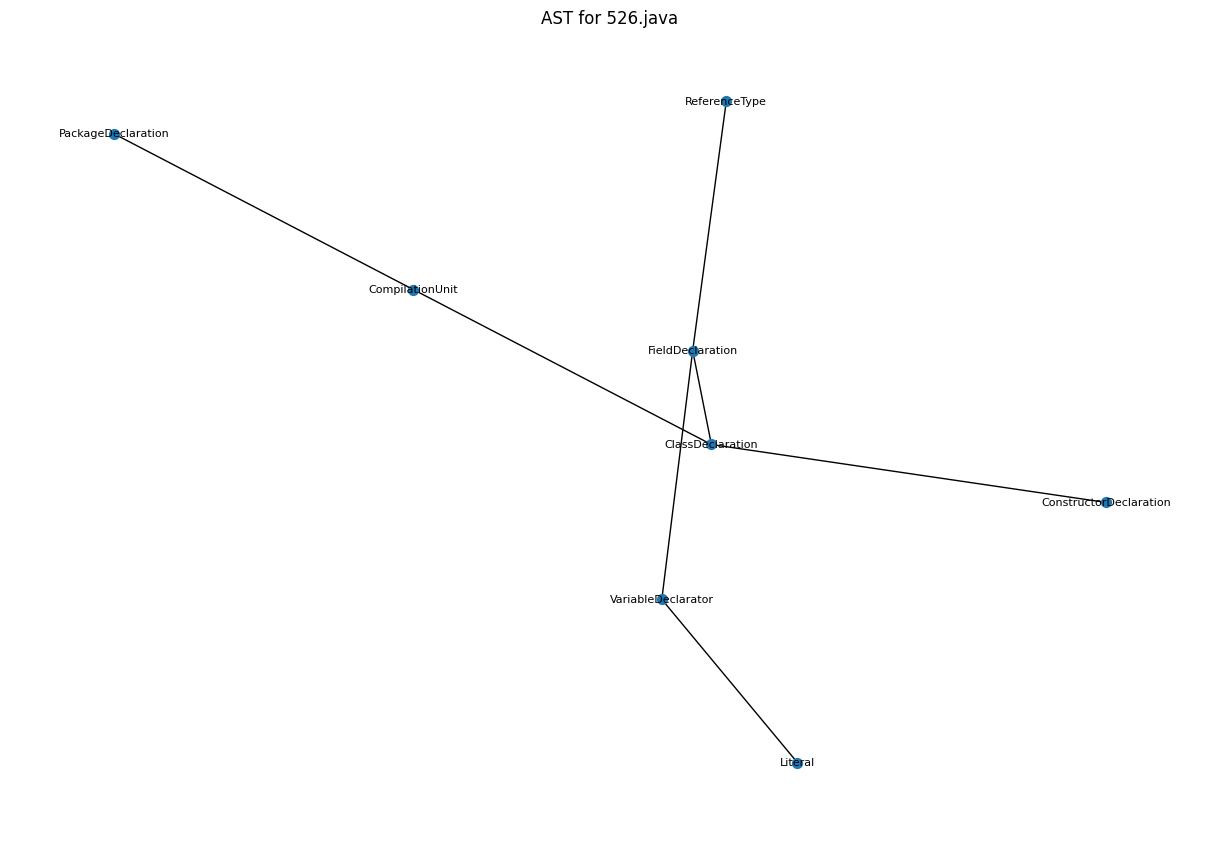

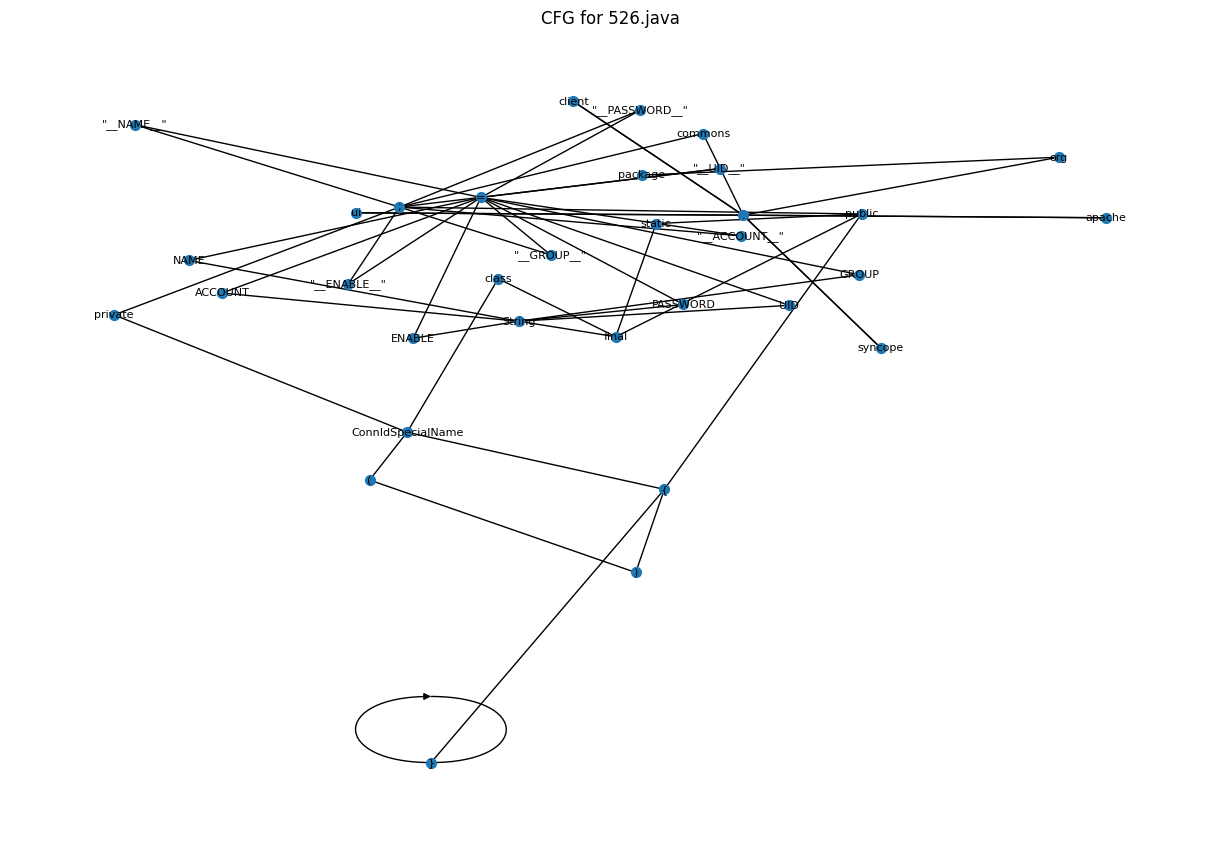


Visualization for 527.java:


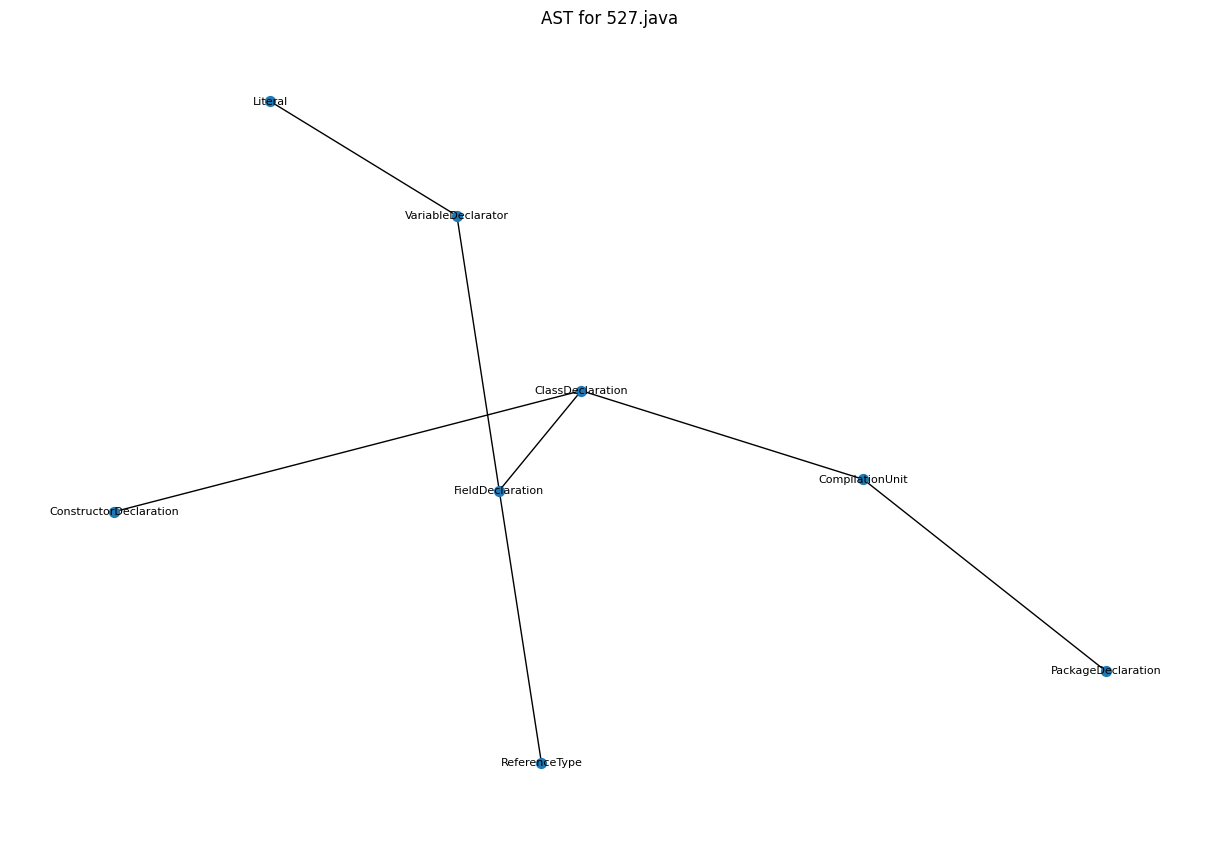

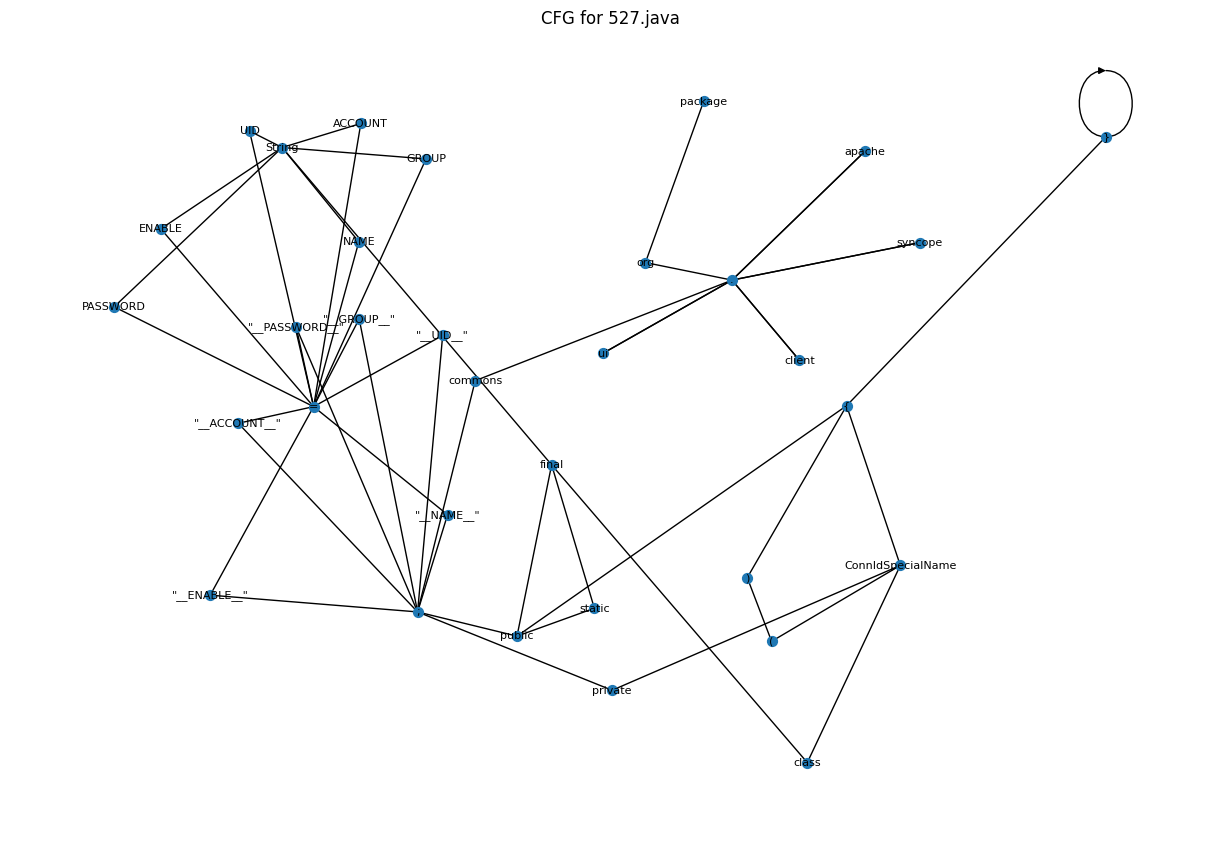


Visualization for 528.java:


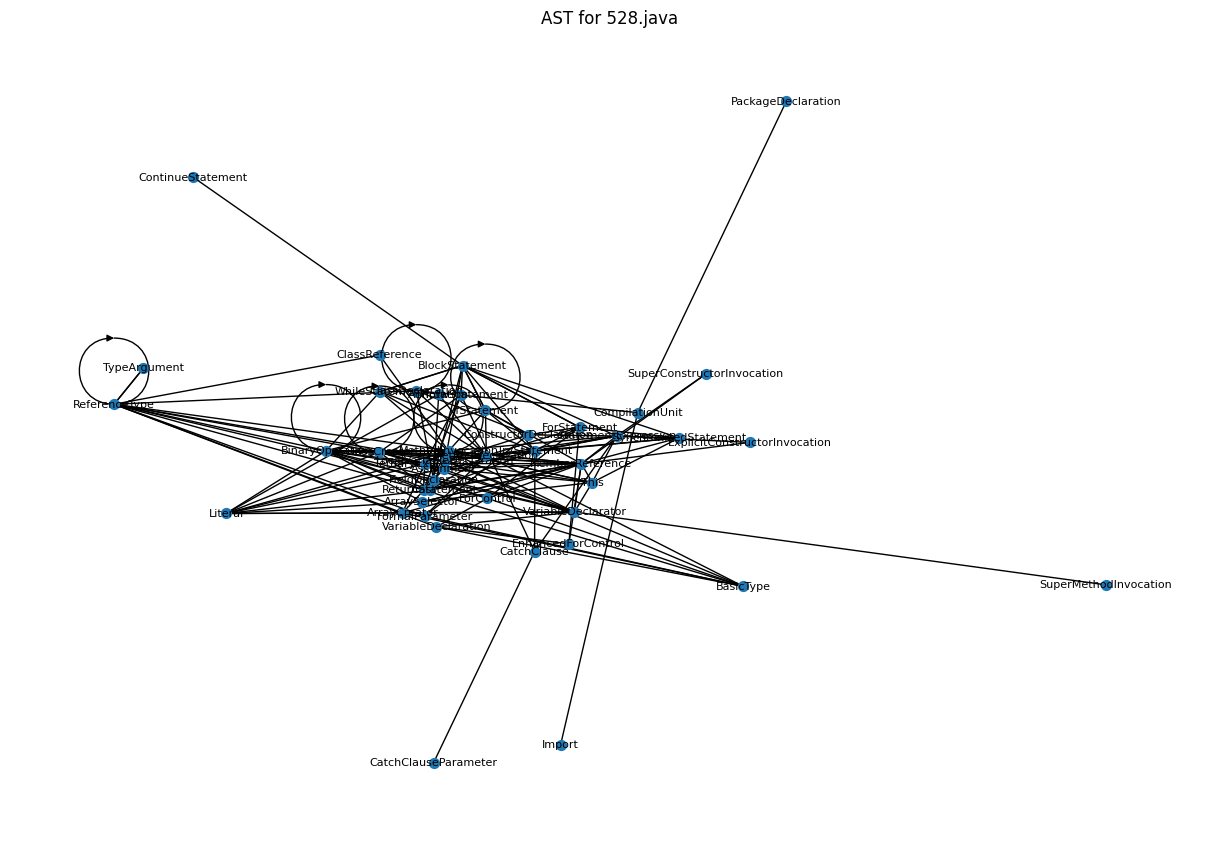

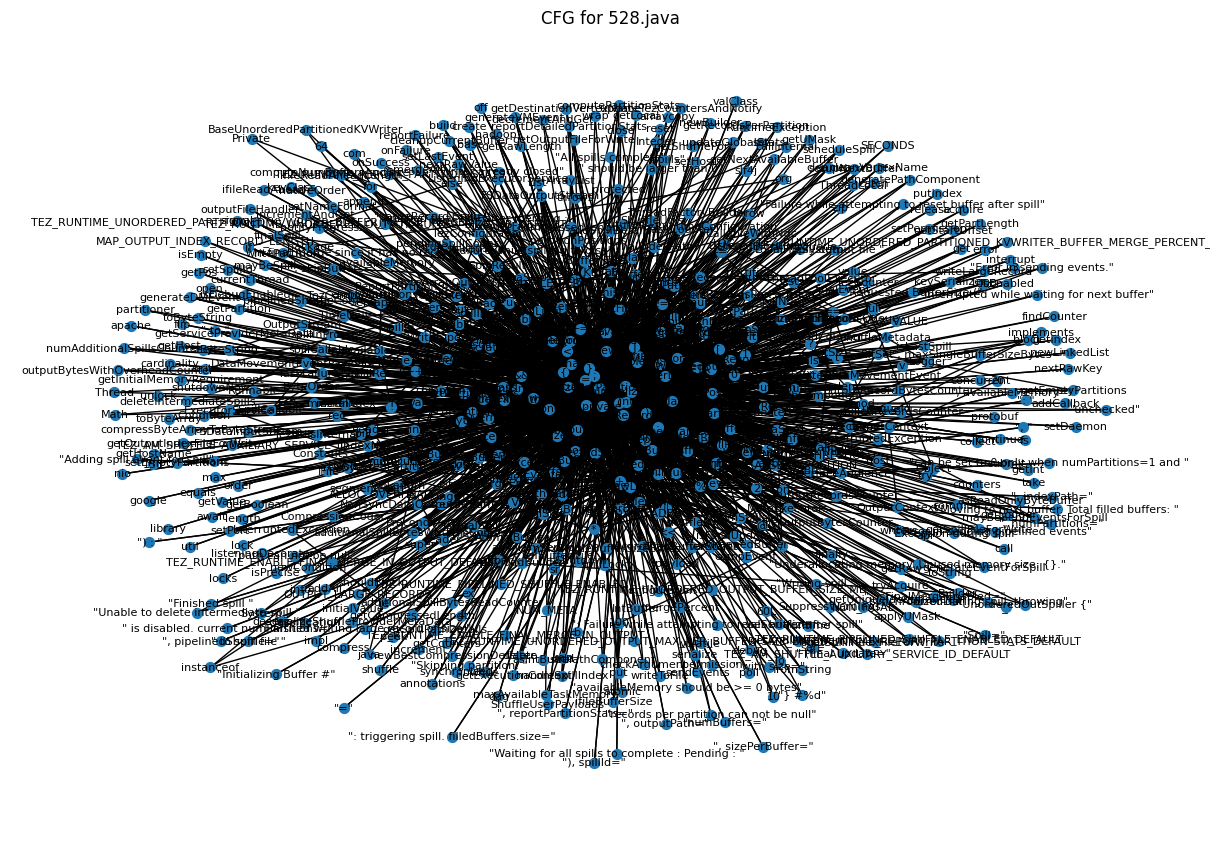


Visualization for 529.java:


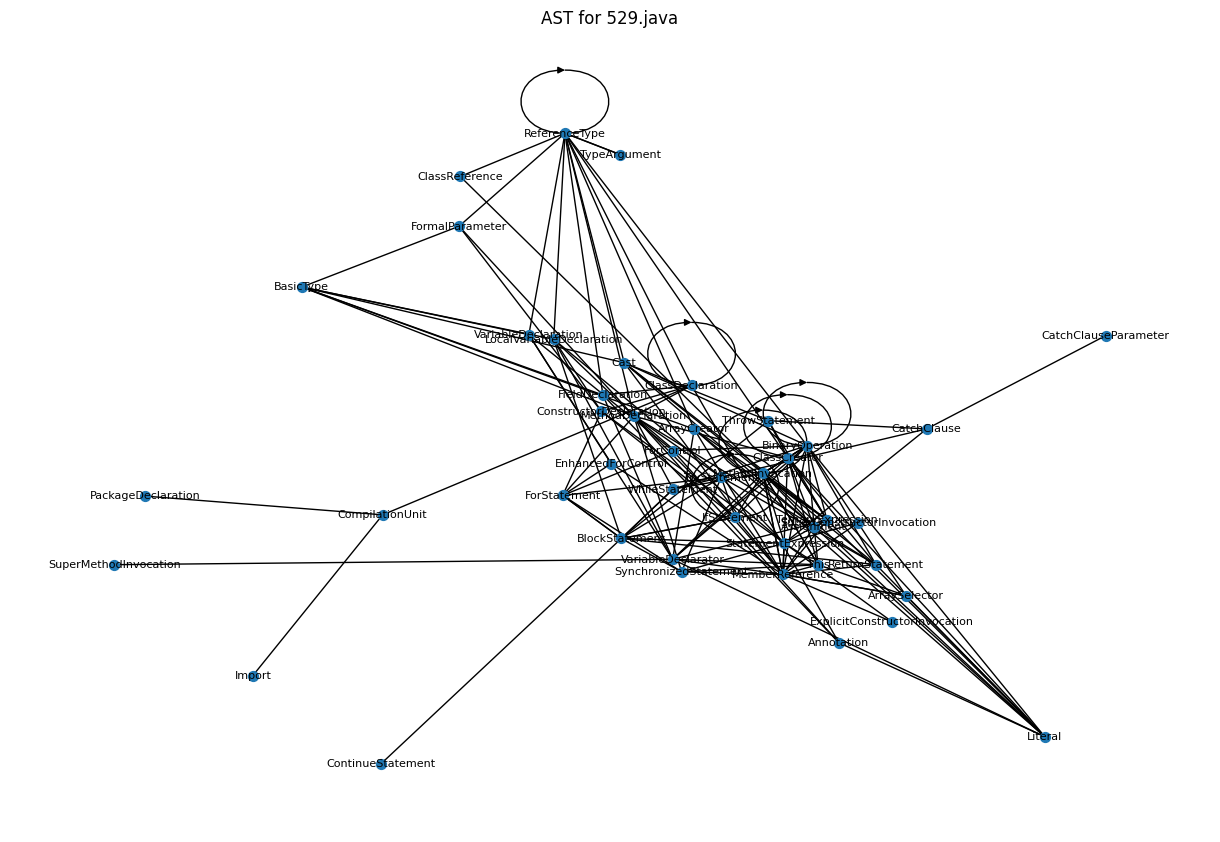

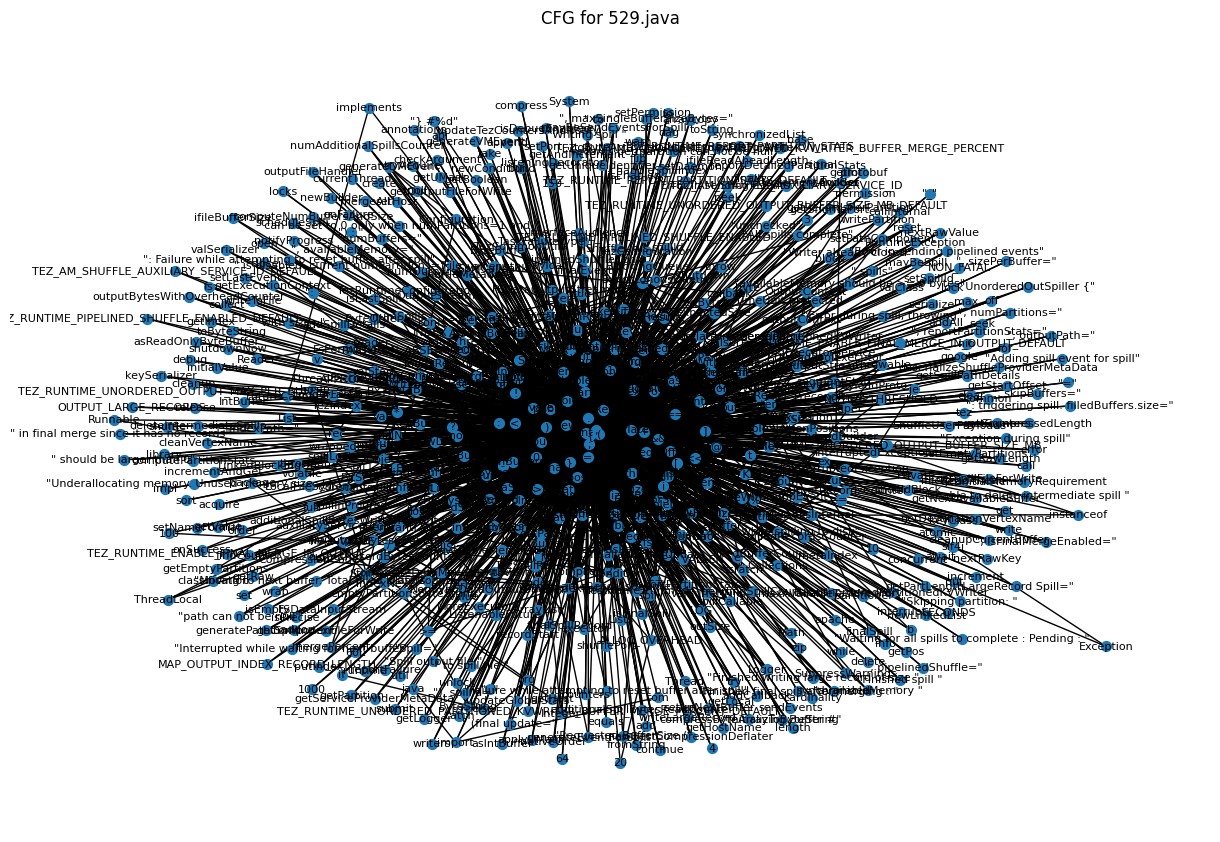


Visualization for 530.java:


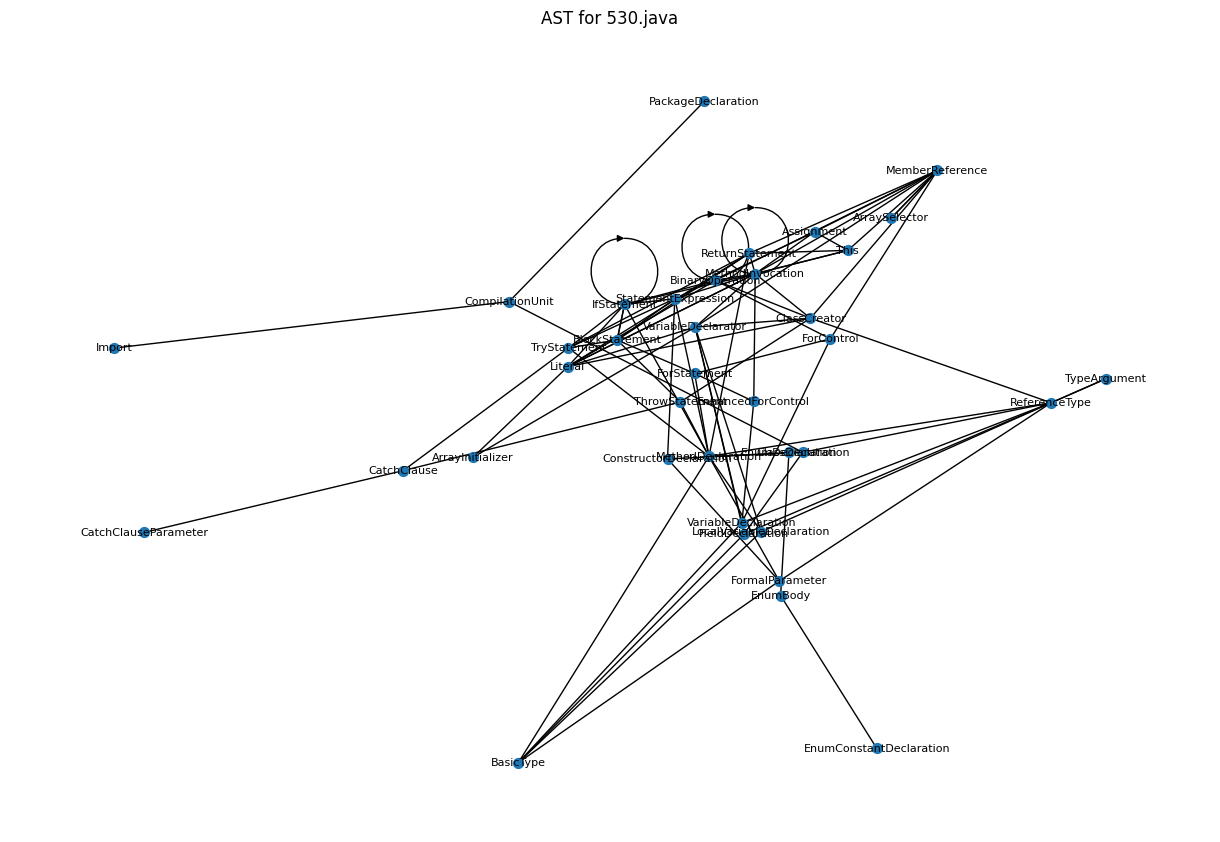

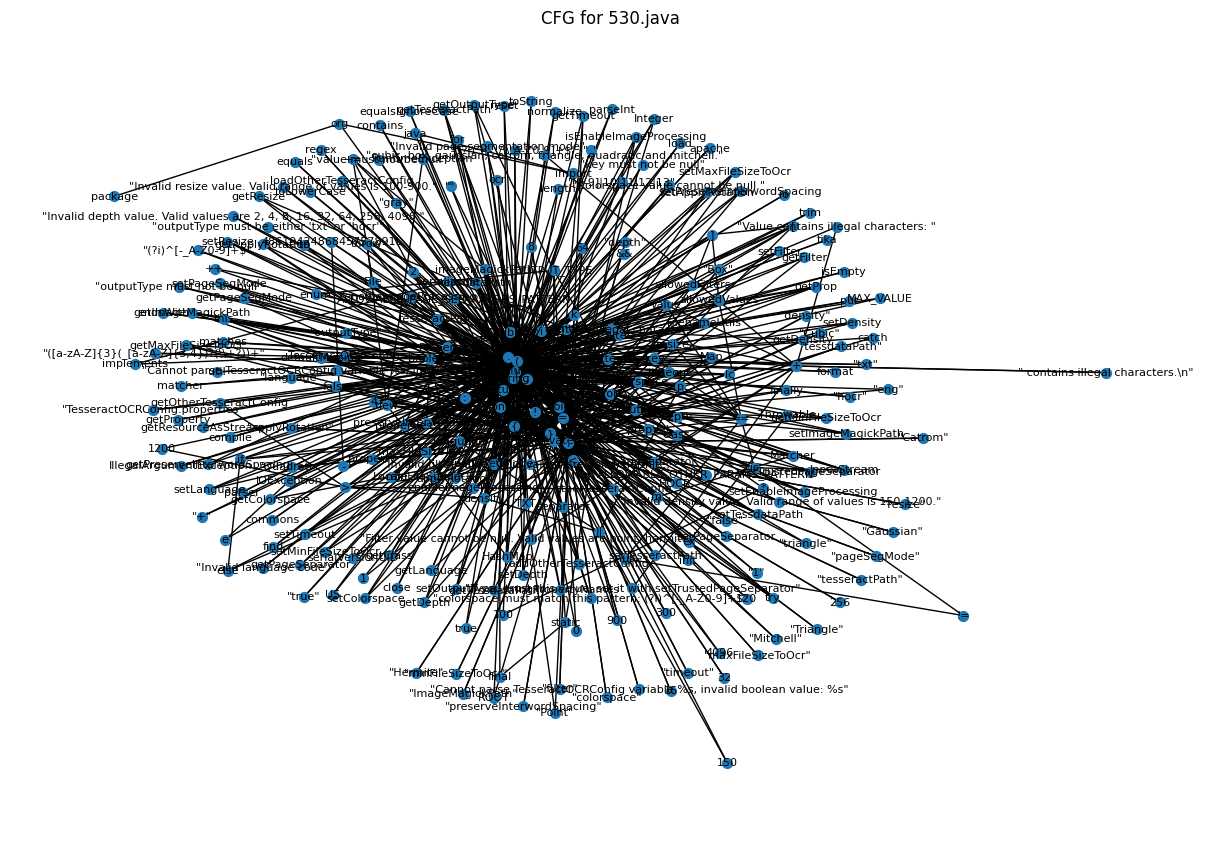

In [ ]:
# Visualization for the first 5 files
def visualize_graph(graph, title):
    plt.figure(figsize=(12, 8))
    try:
        pos = nx.spring_layout(graph, k=0.15, iterations=20)
        nx.draw(graph, pos, with_labels=True, node_size=50, font_size=8, arrows=False)
        plt.title(title)
        plt.show()
    except Exception as e:
        print(f"Visualization failed for {title}: {e}")

for i in range(min(5, len(preprocessed_files))):
    file = preprocessed_files[i]
    print(f"\nVisualization for {file}:")

    # Visualize AST
    ast = ast_trees[i]
    if ast:
        ast_graph = nx.DiGraph()

        def add_nodes_edges(node, parent=None):
            if isinstance(node, javalang.ast.Node):
                node_label = type(node).__name__
                if parent:
                    ast_graph.add_edge(parent, node_label)
                for child in node.children:
                    if isinstance(child, list):
                        for item in child:
                            add_nodes_edges(item, node_label)
                    else:
                        add_nodes_edges(child, node_label)

        add_nodes_edges(ast)
        visualize_graph(ast_graph, f"AST for {file}")
    else:
        print("AST not available for visualization.")

    # Visualize CFG
    cfg = cfg_graphs[i]
    if cfg and cfg.number_of_nodes() > 0:
        visualize_graph(cfg, f"CFG for {file}")
    else:
        print("CFG not available for visualization.")

In [ ]:
# Cell 4: Embedding Generation for AST, CFG, and Combined AST+CFG

from transformers import RobertaTokenizer, RobertaModel
import torch


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
model.eval()  # Set model to evaluation mode

# Function to convert AST to embeddings
def ast_to_embeddings(ast_tree):
    if ast_tree is None:
        return np.zeros(768)  # Assuming CodeBERT base has 768 hidden size
    code_tokens = []

    def traverse(node):
        if isinstance(node, javalang.ast.Node):
            code_tokens.append(type(node).__name__)
            for child in node.children:
                if isinstance(child, list):
                    for item in child:
                        traverse(item)
                else:
                    traverse(child)

    traverse(ast_tree)
    code_string = " ".join(code_tokens)
    inputs = tokenizer(code_string, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Function to convert CFG to embeddings
def cfg_to_embeddings(cfg_graph):
    if cfg_graph is None or cfg_graph.number_of_nodes() == 0:
        return np.zeros(768)
    code_string = " ".join(list(cfg_graph.nodes()))
    inputs = tokenizer(code_string, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding


In [ ]:
# Generate embeddings
ast_embeddings = []
cfg_embeddings = []
combined_embeddings = []

NUM_FILES_FOR_EMBEDDINGS = 4000
selected_ast_trees = ast_trees[:NUM_FILES_FOR_EMBEDDINGS]
selected_cfg_graphs = cfg_graphs[:NUM_FILES_FOR_EMBEDDINGS]

for ast, cfg in tqdm(zip(selected_ast_trees, selected_cfg_graphs), total=len(selected_ast_trees), desc="Generating Embeddings"):
    ast_emb = ast_to_embeddings(ast)
    cfg_emb = cfg_to_embeddings(cfg)
    combined_emb = np.concatenate((ast_emb, cfg_emb))  # Combined embedding of size 1536
    ast_embeddings.append(ast_emb)
    cfg_embeddings.append(cfg_emb)
    combined_embeddings.append(combined_emb)

print("Embeddings generated for AST, CFG, and combined AST+CFG.")


Generating Embeddings: 100%|██████████| 4000/4000 [3:28:47<00:00,  3.13s/it]

Embeddings generated for AST, CFG, and combined AST+CFG.


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Ensure that 'smell' column exists
if 'smell' not in df.columns:
    raise ValueError("The dataset must contain a 'smell' column.")

# Extract 'id' from filenames (assuming filenames are in the format 'id.java')
preprocessed_ids = [int(f.split('.java')[0]) for f in preprocessed_files]
df_preprocessed = df[df['id'].isin(preprocessed_ids)].reset_index(drop=True)

# Use only the 'smell' column as the label
df_preprocessed['label'] = df_preprocessed['smell'].astype(str)

# Encode labels
label_encoder = LabelEncoder()
df_preprocessed['label_encoded'] = label_encoder.fit_transform(df_preprocessed['label'])

# Verify label encoding
print("Label encoding mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")

labels = df_preprocessed['label_encoded'].values[:len(ast_embeddings)]

Label encoding mapping:
0: blob
1: data class
2: feature envy
3: long method


In [ ]:
from sklearn.decomposition import PCA

# Reduce combined embeddings to 768 dimensions
pca = PCA(n_components=768, random_state=42)
combined_embeddings_reduced = pca.fit_transform(combined_embeddings)

print("Combined embeddings reduced to 768 dimensions using PCA.")


Combined embeddings reduced to 768 dimensions using PCA.


In [ ]:
from sklearn.model_selection import train_test_split

# Ensure embeddings are numpy arrays
ast_embeddings = np.array(ast_embeddings)
cfg_embeddings = np.array(cfg_embeddings)
combined_embeddings_reduced = np.array(combined_embeddings_reduced)

# Check for classes with only one sample
unique_labels, label_counts = np.unique(labels, return_counts=True)
problematic_labels = unique_labels[label_counts < 2]

# Remove samples corresponding to problematic labels (if any)
if len(problematic_labels) > 0:
    print(f"Removing samples with labels: {problematic_labels} due to insufficient instances for stratification.")
    valid_indices = np.isin(labels, problematic_labels, invert=True)
    ast_embeddings = ast_embeddings[valid_indices]
    cfg_embeddings = cfg_embeddings[valid_indices]
    combined_embeddings_reduced = combined_embeddings_reduced[valid_indices]
    labels = labels[valid_indices]

# Split data into training and testing sets
X_ast_train, X_ast_test, y_ast_train, y_ast_test = train_test_split(
    ast_embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

X_cfg_train, X_cfg_test, y_cfg_train, y_cfg_test = train_test_split(
    cfg_embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(
    combined_embeddings_reduced, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Data split into training and testing sets:")
print(f"Training samples (AST): {len(X_ast_train)}, Testing samples (AST): {len(X_ast_test)}")
print(f"Training samples (CFG): {len(X_cfg_train)}, Testing samples (CFG): {len(X_cfg_test)}")
print(f"Training samples (Combined): {len(X_combined_train)}, Testing samples (Combined): {len(X_combined_test)}")

Data split into training and testing sets:
Training samples (AST): 3200, Testing samples (AST): 800
Training samples (CFG): 3200, Testing samples (CFG): 800
Training samples (Combined): 3200, Testing samples (Combined): 800


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to train and evaluate a classifier
def train_evaluate_classifier(X_train, X_test, y_train, y_test, description=""):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"--- {description} ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}\n")

    return {
        'description': description,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Train and evaluate classifiers
metrics_ast = train_evaluate_classifier(X_ast_train, X_ast_test, y_ast_train, y_ast_test, "AST Embeddings")
metrics_cfg = train_evaluate_classifier(X_cfg_train, X_cfg_test, y_cfg_train, y_cfg_test, "CFG Embeddings")
metrics_combined = train_evaluate_classifier(X_combined_train, X_combined_test, y_combined_train, y_combined_test, "Combined AST+CFG Embeddings")


NameError: name 'X_ast_train' is not defined

In [ ]:
import javalang
import networkx as nx
import matplotlib.pyplot as plt

# Sample AST Exploration for RL and LL paths
def explore_ast_paths(ast_tree):
    paths = []

    def traverse(node, current_path):
        if isinstance(node, javalang.ast.Node):
            current_path.append(type(node).__name__)
            for child in node.children:
                if isinstance(child, list):
                    for item in child:
                        traverse(item, current_path[:])
                else:
                    traverse(child, current_path[:])
        elif isinstance(node, str):  # Leaf node
            current_path.append(node)
            paths.append(" -> ".join(current_path))

    traverse(ast_tree, [])
    return paths[:10]  # Display first 10 paths for brevity


# Sample CFG Exploration for LL paths
def explore_cfg_paths(cfg_graph):
    paths = []
    for start_node in cfg_graph.nodes():
        for end_node in cfg_graph.nodes():
            if start_node != end_node and nx.has_path(cfg_graph, start_node, end_node):
                path = nx.shortest_path(cfg_graph, source=start_node, target=end_node)
                paths.append(" -> ".join(path))
    return paths[:10]  # Display first 10 paths for brevity


# Assuming you already have AST and CFG for a file
ast = generate_ast("java_files_corrected/526.java")  # Adjust file path
cfg = generate_cfg("java_files_corrected/526.java")  # Adjust file path

# Extract paths
print("--- AST RL and LL Paths ---")
ast_paths = explore_ast_paths(ast)
print("\n".join(ast_paths))

print("\n--- CFG LL Paths ---")
cfg_paths = explore_cfg_paths(cfg)
print("\n".join(cfg_paths))

# Combined Paths (AST + CFG)
print("\n--- Combined AST + CFG RL and LL Paths ---")
combined_paths = ast_paths + cfg_paths  # Example combination
print("\n".join(combined_paths[:10]))
